In [354]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
# from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import seaborn as sns

# colors = sns.diverging_palette(240, 10, n=2) # red to blue
colors = sns.diverging_palette(150, 275, s=80, l=55, n=2) #green to purple
colors[0], colors[1] = colors[1], colors[0] # switch colors
cmap = 'PRGn'

from datetime import datetime
import os
from os import path

FILEPATH = os.path.join(os.getcwd(), 'figs\\')
CLFPATH = os.path.join(os.getcwd(), 'clf\\')

from scipy.stats import norm

In [296]:
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

mods = ['KNN', 'SVC', 'nuSVC', 'XGBoost', 'MLP', 'RF', 'QDA'] # list of ML models
data = ['Gaussian XOR', 'Uniform XOR', 'Spiral', 'Gaussian R-XOR', 'Gaussian S-XOR'] # list of datasets

## Date/time of experiment

In [3]:
print(datetime.now())

2020-11-27 05:55:56.173419


## Revised gaussian XOR generator

In [4]:
def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

In [401]:
def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None, contain=True, cc=False):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    lim = abs(mean[0])
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    elif mean[0] == -2 and mean[1] == -2:
        mean = mean + 1
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=mnt[i*(2**k) + j])
            if abs(mean[0]) == 0.5:
                temp[:, 0] += i*(1/2**(k-1))
                temp[:, 1] += j*(1/2**(k-1))
                
            elif abs(mean[0]) == 1:
                temp[:, 0] += i*2
                temp[:, 1] += j*2

            # screen out values outside the boundary
            if contain:
                if cc:
                # circular bbox
                    idx_oob = np.where(np.sqrt((temp**2).sum(axis=1)) > lim)

                    for l in idx_oob:
                        
                        while True:
                            temp2 = np.random.multivariate_normal(mean, cov_scale * np.eye(d), size=1)

                            if np.sqrt((temp2**2).sum(axis=1)) < lim:
                                temp[l] = temp2
                                break
                else: 
                # square bbox
                    idx_oob = np.where(abs(temp) > lim)
                    
                    for l in idx_oob:
                        
                        while True:
                            temp2 = np.random.multivariate_normal(mean, cov_scale * np.eye(d), size=1)

                            if (abs(temp2) < lim).all():
                                temp[l] = temp2
                                break
            
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
            
        R = generate_2d_rotation(angle_params)
        X = X @ R
        
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)

In [402]:
def generate_spirals(N, K=5, noise = 0.5, acorn = None, density=0.3, rng = 1):

    #N number of poinst per class
    #K number of classes
    X = []
    Y = []

    size = int(N/K) # equal number of points per feature

    if acorn is not None:
        np.random.seed(acorn)
    
    if K == 2:
        turns = 2
    elif K==3:
        turns = 2.5
    elif K==5:
        turns = 3.5
    elif K==7:
        turns = 4.5
    elif K==1:
        turns = 1
    else:
        print ("sorry, can't currently surpport %s classes " %K)
        return
    
    mvt = np.random.multinomial(N, 1/K * np.ones(K))
    
    if K == 2:
        r = np.random.uniform(0, rng, size=size)
        r = np.sort(r)
        t = np.linspace(0,  np.pi* 4 * turns/K, size) + noise * np.random.normal(0, density, size)
        dx = r * np.cos(t)
        dy = r * np.sin(t)

        X.append(np.vstack([dx, dy]).T)
        X.append(np.vstack([-dx, -dy]).T)
        Y += [0] * size 
        Y += [1] * size
    else:    
        for j in range(1, K+1):
            r = np.linspace(0.01, rng, int(mvt[j-1]))
            t = np.linspace((j-1) * np.pi *4 *turns/K,  j* np.pi * 4* turns/K, int(mvt[j-1])) + noise * np.random.normal(0, density, int(mvt[j-1]))
            dx = r * np.cos(t)
            dy = r * np.sin(t)

            dd = np.vstack([dx, dy]).T        
            X.append(dd)
            #label
            Y += [j-1] * int(mvt[j-1])
    return np.vstack(X), np.array(Y).astype(int)

In [7]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

In [86]:
def pdf(x, rotate=False, sig=0.25):
    
    # Generates true XOR posterior
    if rotate:
        mu01 = np.array([-0.5,0])
        mu02 = np.array([0.5,0])
        mu11 = np.array([0,0.5])
        mu12 = np.array([0,-0.5])
    else:
        mu01 = np.array([-0.5,0.5])
        mu02 = np.array([0.5,-0.5])
        mu11 = np.array([0.5,0.5])
        mu12 = np.array([-0.5,-0.5])
    cov = sig * np.eye(2)
    inv_cov = np.linalg.inv(cov) 

    p0 = (
        np.exp(-(x - mu01)@inv_cov@(x-mu01).T) 
        + np.exp(-(x - mu02)@inv_cov@(x-mu02).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    p1 = (
        np.exp(-(x - mu11)@inv_cov@(x-mu11).T) 
        + np.exp(-(x - mu12)@inv_cov@(x-mu12).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    # return p0-p1
    return p1/(p0+p1)

## Sham spiral true posterior

In [9]:
def pdf_spiral(N, K=2, noise=1, acorn = None, density=0.5, rng = 1):
    
    #N number of poinst per class
    #K number of classes
    X, Y, Z = [],[],[]
    X0, X1, Z0, Z1 = [], [], [], []

    size = int(N/K) # equal number of points per feature

    if acorn is not None:
        np.random.seed(acorn)
    
    if K == 2:
        turns = 2
    elif K==3:
        turns = 2.5
    elif K==5:
        turns = 3.5
    elif K==7:
        turns = 4.5
    elif K==1:
        turns = 1
    else:
        print ("sorry, can't currently surpport %s classes " %K)
        return
    
    mvt = np.random.multinomial(N, 1/K * np.ones(K))
    
    if K == 2:
        r = np.random.uniform(0, rng, size=size)
        r = np.sort(r)

        t = np.linspace(0, np.pi* 4 * turns/K, size) + noise * np.random.normal(0, density, size)
        dx = r * np.cos(t)
        dy = r * np.sin(t)

        # print(np.vstack([dx, dy]).T)

        # print(norm(0,1).pdf(np.vstack([dx, dy]).T)[:,0])
        Z0 += [1 for i in norm(0,1).pdf(np.vstack([dx, dy]).T)[:,0]]
        Z1 += [1 for i in norm(0,1).pdf(np.vstack([-dx, -dy]).T)[:,1]]
        
        Z += [1 for i in norm(0,1).pdf(np.vstack([dx, dy]).T)[:,0]]
        Z += [0 for i in norm(0,1).pdf(np.vstack([-dx, -dy]).T)[:,1]]
        # Z += np.subtract(Z0,Z1).tolist()
        # Z += np.subtract(Z1,Z0).tolist()
        # Z += np.split(np.array(norm(0,1).pdf(np.vstack([dx, dy]).T)[:,0]), 1)
        # Z += np.split(np.array(norm(0,1).pdf(np.vstack([-dx, -dy]).T)[:,0]), 1)

        # Z += [0.1] * size
        # Z += [0.1] * size

        X.append(np.vstack([dx, dy]).T)
        X.append(np.vstack([-dx, -dy]).T)

        X0.append(np.vstack([dx, dy]).T)
        X1.append(np.vstack([-dx, -dy]).T)

        Y += [0] * size 
        Y += [1] * size
    else:    
        for j in range(1, K+1):
            r = np.linspace(0.01, rng, int(mvt[j-1]))
            t = np.linspace((j-1) * np.pi *4 *turns/K,  j* np.pi * 4* turns/K, int(mvt[j-1])) + noise * np.random.normal(0, density, int(mvt[j-1]))
            dx = r * np.cos(t)
            dy = r * np.sin(t)

            dd = np.vstack([dx, dy]).T        
            X.append(dd)
            #label
            Y += [j-1] * int(mvt[j-1])
    return np.vstack(X), np.array(Y).astype(int), Z, np.vstack(X0), np.vstack(X1), Z0, Z1


## Spiral True posterior (work in progress)

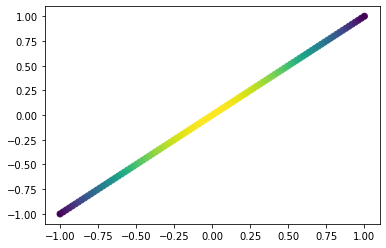

In [10]:
def pdf1(x, rotate=False, sig=0.25):
    
    # Generates true XOR posterior
    if rotate:
        mu01 = np.array([0,0])
        mu02 = np.array([0,0])
        mu11 = np.array([0,0])
        mu12 = np.array([0,0])
    else:
        mu01 = np.array([0,.5])
        mu02 = np.array([1,0])
        mu11 = np.array([0,.5])
        mu12 = np.array([1,0])
    cov = sig * np.eye(2)
    inv_cov = np.linalg.inv(cov) 

    p0 = (
        np.exp(-(x - mu01)@inv_cov@(x-mu01).T) 
        + np.exp(-(x - mu02)@inv_cov@(x-mu02).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    p1 = (
        np.exp(-(x - mu11)@inv_cov@(x-mu11).T) 
        + np.exp(-(x - mu12)@inv_cov@(x-mu12).T)
    )/(2*np.pi*np.sqrt(np.linalg.det(cov)))

    # return p0-p1
    print(p1/(p0+p1))
    return p1/(p0+p1)

tx = np.linspace(-1,1,100)
ty = np.linspace(-1,1,100)

tX = np.c_[(tx,ty)]
tX.shape
# for i in tX:
#     pdf1(i)
# np.vstack((tx,ty))
# plt.plot(pdf(tX));
# pdf(tx)
# plt.plot(norm(0,1).pdf(tX))
tC = norm(0,1).pdf(tX)
plt.scatter(tx,ty,c=tC[:,0])

In [11]:
def generate_mask(l=-2, r=2, h=0.01):
    
    x = np.arange(l,r,h)
    y = np.arange(l,r,h)
    x,y = np.meshgrid(x,y)
    sample = np.c_[x.ravel(),y.ravel()]

    return sample#[:,0], sample[:,1]

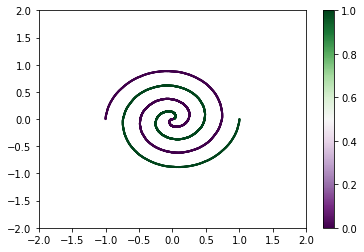

In [104]:
a, b, c, d, e, f, g = pdf_spiral(6000, noise=0, K=2)#generate_spirals(750, K=2)
plt.scatter(a[:,0],a[:,1], c=c, cmap=cmap, s=1)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.colorbar()

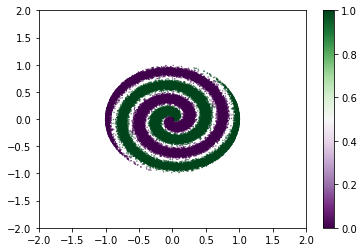

In [191]:
a, b, c, d, e, f, g = pdf_spiral(100000, noise=.9, K=2)#generate_spirals(750, K=2)
plt.scatter(a[:,0],a[:,1], c=c, cmap=cmap, s=0.1)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.colorbar()

In [15]:
# a, b, c = pdf_spiral(750, K=2)#generate_spirals(750, K=2)
# plt.scatter(generate_mask(h=0.01)[:,0],generate_mask(h=0.01)[:,1], c=newc6, cmap='RdBu_r')
# plt.colorbar()

In [16]:
# filename = 'clf/20201021_trueSpiral_5k.pickle'
# with open(filename, 'wb') as f:
#     pickle.dump([newc11, newc12], f)

In [17]:
def normalize(p, q):
    z = p - q
    z = (z - min(z)) / (max(z) - min(z))

    return z

In [18]:
from IPython.display import clear_output

def overlay_points(x1, x2, p):

    # X = x2.copy()
    X = np.zeros(len(x2)) + 0.5
    idx_list = [i for i in range(len(x2))]#np.linspace(0, len(x2))

    if len(x1) > len(x2):
        print('ERROR: size of x2 too small')
        return

    for idx, i in enumerate(x1):
        bestD = None
        bestX = None

        clear_output(wait=True)
        

        for j in idx_list:
            
            tempD = np.sqrt( (i[0]-x2[j][0])**2 + (i[1]-x2[j][1])**2)

            if bestD == None:
                bestD = tempD
                bestX = j
            
            if bestD > tempD:
                bestD = tempD
                bestX = j

        print(idx, '/', len(x1), '[', bestX ,']')
        X[bestX] = p[idx]
        # x2.remove(j)
        idx_list.remove(bestX)

    return X


In [453]:
def true_xor(l=-2, r=2, h=0.01, rotate=False, sig=0.25, cc=False):
    X = generate_mask(l=l, r=r, h=h)
    
    z = np.zeros(len(X),dtype=float)

    for ii,x in enumerate(X):
        if np.any([x <= -1.0, x >= 1.0]) and cc==False: #or x.any() > 1
            z[ii] = 0.5
            # pass
        elif np.sqrt((x**2).sum(axis=0)) > 1 and cc==True:
            z[ii] = 0.5
        else:
            z[ii] = 1-pdf(x, rotate=rotate, sig=sig)#)/np.sqrt(4)
        # z[ii] = 1-pdf(x, rotate=rotate, sig=sig)

    z = (z - min(z)) / (max(z) - min(z))

    return X[:,0], X[:,1], z

In [20]:
#likelihood
def true_xor_likelihood(l=-2, r=2, h=0.01, rotate=False, sig=0.25):
    X = generate_mask(l=l, r=r, h=h)
    
    z = np.zeros(len(X),dtype=float)

    for ii,x in enumerate(X):
    #     if np.any([x <= -1.0, x >= 1.0]): #or x.any() > 1
    #         z[ii] = 0.5
    #     else:
        z[ii] = (1-pdf(x))/np.sqrt(4)
        # z[ii] = 1-pdf(x, rotate=rotate, sig=sig)

    z = (z - min(z)) / (max(z) - min(z))

    return X[:,0], X[:,1], z

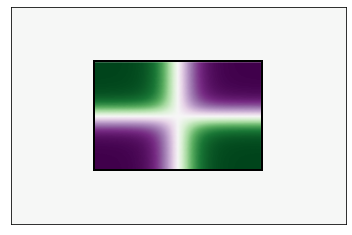

In [455]:
h = 0.01
# tempX = generate_mask(h=h)
tempX, tempY, tempC = true_xor(h=h, rotate=False, sig=0.25)

fig, axs = plt.subplots(1,1)

axs.set_xticks([])
axs.set_yticks([])
axs.set_xlim(np.multiply([-2,2], 1))
axs.set_ylim(np.multiply([-2,2], 1)) 
axs.scatter(tempX, tempY, c=tempC, s=1, cmap=cmap)
axs.add_patch(Rectangle(
                (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))

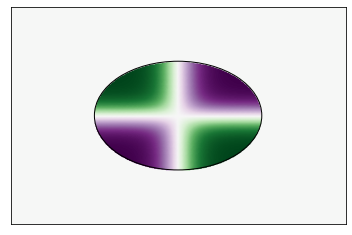

In [454]:
h = 0.01
# tempX = generate_mask(h=h)
tempX, tempY, tempC = true_xor(h=h, rotate=False, sig=0.25, cc=True)

fig, axs = plt.subplots(1,1)

axs.set_xticks([])
axs.set_yticks([])
axs.set_xlim(np.multiply([-2,2], 1))
axs.set_ylim(np.multiply([-2,2], 1)) 
axs.scatter(tempX, tempY, c=tempC, s=1, cmap=cmap)
# axs.add_patch(Rectangle(
#                 (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))
axs.add_patch(Circle((0,0), radius=1, edgecolor='k', fill=False))

In [458]:
def true_Uxor(l=-2, r=2, h=0.01, cc=False):

    X = generate_mask(l=l, r=r, h=h)

    l=-1
    r=1

    z = np.zeros(len(X),dtype=float) + 0.5

    for i, loc in enumerate(X):
        X0 = loc[0]
        X1 = loc[1]
        
        if X0 > l and X0 < 0 and X1 < r and X1 > 0:
            z[i] = 1
        elif X0 > 0 and X0 < r and X1 < r and X1 > 0:
            z[i] = 0
        elif X0 > l and X0 < 0 and X1 < 0 and X1 > l:
            z[i] = 0
        elif X0 > 0 and X0 < r and X1 < 0 and X1 > l:
            z[i] = 1
        
        if np.sqrt((np.c_[X0,X1]**2).sum(axis=1)) > 1 and cc==True:
            z[i] = 0.5

    return X[:,0],X[:,1],z
            

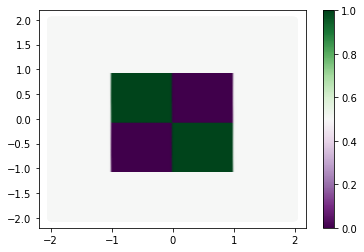

In [449]:
h = 0.01
# tempX = generate_mask(h=h)
tempX, tempY, tempC = true_Uxor(h=h)
plt.scatter(tempX, tempY, c=tempC, cmap=cmap)
plt.colorbar()

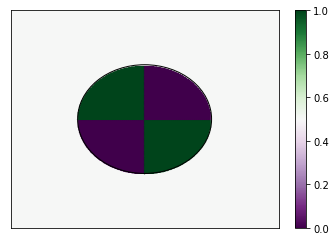

In [460]:
h = 0.01
# tempX = generate_mask(h=h)
tempX, tempY, tempC = true_Uxor(h=h, cc=True)
fig, axs = plt.subplots(1,1)

axs.set_xticks([])
axs.set_yticks([])
axs.set_xlim(np.multiply([-2,2], 1))
axs.set_ylim(np.multiply([-2,2], 1)) 
pms = axs.scatter(tempX, tempY, c=tempC, s=1, cmap=cmap)
# axs.add_patch(Rectangle(
#                 (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))
axs.add_patch(Circle((0,0), radius=1, edgecolor='k', fill=False))
fig.colorbar(pms)

In [399]:
def generate_uniform_XOR(b=1, N=750, cc=False):

    boundary = np.random.multinomial(N, [1/4.]*4)
    bcum = np.cumsum(boundary)

    X = np.array([[0,0]])
    Y = np.zeros(N)
    Y[bcum[0]:bcum[2]] = 1
    ol = 0.0 # degree of overlap

    for i in range(2):
        for j in range(2):
            
            idx = 2*i+j

            if i == 1:
                tempX = np.random.uniform(ol,-b,boundary[idx])
            else: 
                tempX = np.random.uniform(-ol,b,boundary[idx])

            if j == 1:
                tempY = np.random.uniform(ol,-b,boundary[idx])
            else:
                tempY = np.random.uniform(-ol,b,boundary[idx])


            temp = np.c_[tempX,tempY]

            if cc:
                # circular bbox
                idx_oob = np.where(np.sqrt((temp**2).sum(axis=1)) > 1)
                # print(idx_oob)

                for l in idx_oob:
                    
                    while True:

                        if i == 1:
                            tempX = np.random.uniform(ol,-b,1)
                        else: 
                            tempX = np.random.uniform(-ol,b,1)

                        if j == 1:
                            tempY = np.random.uniform(ol,-b,1)
                        else:
                            tempY = np.random.uniform(-ol,b,1)

                        temp2 = np.c_[tempX,tempY]

                        if np.sqrt((temp2**2).sum(axis=1)) < 1:
                            temp[l] = temp2
                            break

                X = np.concatenate((X, temp))

            else:
                X = np.concatenate((X, np.c_[tempX, tempY]))
            
    return X[1:], Y.astype('int')

In [488]:
def select_dataset(dset=0, cc=False):

    if cc:
        if dset == 0:
            return CgausX, CgausY, Cnew_gausX, Cnew_gausY
        elif dset == 1:
            return CunifX, CunifY, Cnew_unifX, Cnew_unifY
        elif dset == 2:
            return spirX, spirY, new_spirX, new_spirY
        elif dset == 3:
            return CgausRX, CgausRY, Cnew_gausRX, Cnew_gausRY
        elif dset == 4:
            return CgausSX, CgausSY, Cnew_gausSX, Cnew_gausSY
        else:
            print ("ERROR: DATASET DOES NOT EXIST")
            return
    else:

        if dset == 0:
            return gausX, gausY, new_gausX, new_gausY
        elif dset == 1:
            return unifX, unifY, new_unifX, new_unifY
        elif dset == 2:
            return spirX, spirY, new_spirX, new_spirY
        elif dset == 3:
            return gausRX, gausRY, new_gausRX, new_gausRY
        elif dset == 4:
            return gausSX, gausSY, new_gausSX, new_gausSY
        else:
            print ("ERROR: DATASET DOES NOT EXIST")
            return

## Generating gaussian data

In [403]:
gausX, gausY = generate_gaussian_parity(750, mean=np.array([-1,-1]), cov_scale=0.1, angle_params=np.pi)
new_gausX, new_gausY = generate_gaussian_parity(750, mean=np.array([-2,-2]), cov_scale=0.4, angle_params=np.pi)

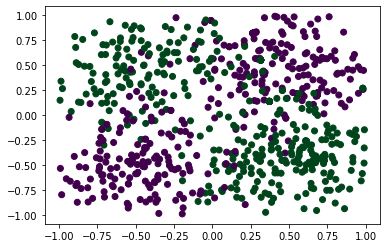

In [404]:
# plt.scatter(gausX[:,0],gausX[:,1], c=get_colors(colors, gausY))
plt.scatter(gausX[:,0],gausX[:,1], c=gausY, cmap=cmap)

In [405]:
CgausX, CgausY = generate_gaussian_parity(750, mean=np.array([-1,-1]), cov_scale=0.1, angle_params=np.pi, cc=True)
Cnew_gausX, Cnew_gausY = generate_gaussian_parity(750, mean=np.array([-2,-2]), cov_scale=0.4, angle_params=np.pi, cc=True)

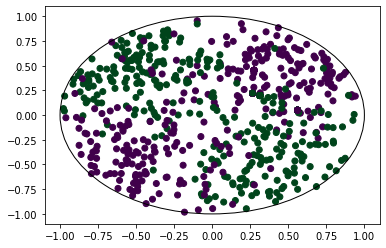

In [406]:
fig, ax = plt.subplots()
ax.scatter(CgausX[:,0],CgausX[:,1], c=gausY, cmap=cmap)
ax.add_patch(Circle((0,0), radius=1, edgecolor='k', fill=False))

In [407]:
gausRX, gausRY = generate_gaussian_parity(750, mean=np.array([-1,-1]), cov_scale=0.1, angle_params=np.pi/4)
new_gausRX, new_gausRY = generate_gaussian_parity(750, mean=np.array([-2,-2]), cov_scale=0.4, angle_params=np.pi/4)

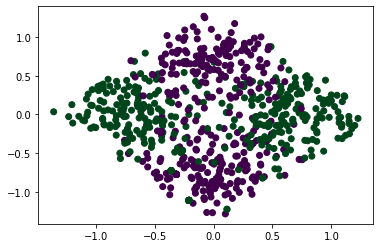

In [408]:
# plt.scatter(gausRX[:,0],gausRX[:,1], c=get_colors(colors, gausRY))
plt.scatter(gausRX[:,0],gausRX[:,1], c=gausRY, cmap=cmap)

In [409]:
CgausRX, CgausRY = generate_gaussian_parity(750, mean=np.array([-1,-1]), cov_scale=0.1, angle_params=np.pi/4, cc=True)
Cnew_gausRX, Cnew_gausRY = generate_gaussian_parity(750, mean=np.array([-2,-2]), cov_scale=0.4, angle_params=np.pi/4, cc=True)

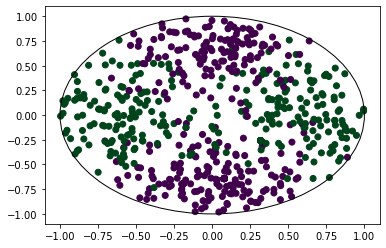

In [410]:
fig, ax = plt.subplots()
ax.scatter(CgausRX[:,0],CgausRX[:,1], c=CgausRY, cmap=cmap)
ax.add_patch(Circle((0,0), radius=1, edgecolor='k', fill=False))

In [94]:
gausSX, gausSY = generate_gaussian_parity(750, mean=np.array([-1,-1]), cov_scale=0.01, angle_params=np.pi)
new_gausSX, new_gausSY = generate_gaussian_parity(750, mean=np.array([-2,-2]), cov_scale=0.12, angle_params=np.pi)

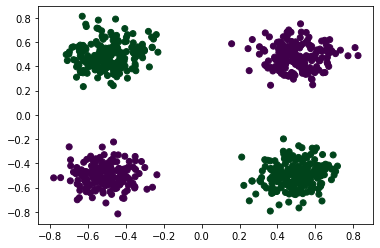

In [95]:
# plt.scatter(gausSX[:,0],gausSX[:,1], c=get_colors(colors, gausSY))
plt.scatter(gausSX[:,0],gausSX[:,1], c=gausSY, cmap=cmap)

In [411]:
CgausSX, CgausSY = generate_gaussian_parity(750, mean=np.array([-1,-1]), cov_scale=0.01, angle_params=np.pi, cc=True)
Cnew_gausSX, Cnew_gausSY = generate_gaussian_parity(750, mean=np.array([-2,-2]), cov_scale=0.12, angle_params=np.pi, cc=True)

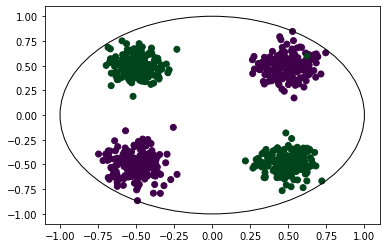

In [412]:
fig, ax = plt.subplots()
ax.scatter(CgausSX[:,0],CgausSX[:,1], c=CgausSY, cmap=cmap)
ax.add_patch(Circle((0,0), radius=1, edgecolor='k', fill=False))

## Generating uniform XOR data

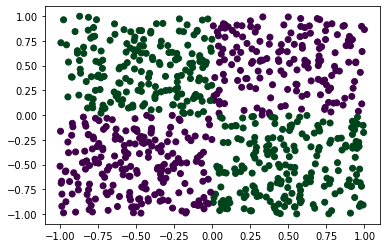

In [413]:
unifX, unifY = generate_uniform_XOR()
new_unifX, new_unifY = generate_uniform_XOR(b=2)
# plt.scatter(unifX[:,0], unifX[:,1], c=get_colors(colors, unifY))
plt.scatter(unifX[:,0],unifX[:,1], c=unifY, cmap=cmap)

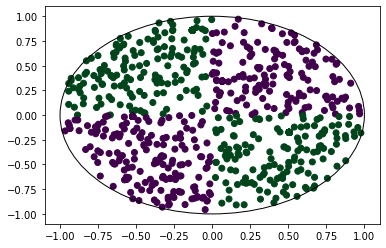

In [417]:
CunifX, CunifY = generate_uniform_XOR(cc=True)
Cnew_unifX, Cnew_unifY = generate_uniform_XOR(cc=True)
fig, ax = plt.subplots()
ax.scatter(CunifX[:,0],CunifX[:,1], c=CunifY, cmap=cmap)
ax.add_patch(Circle((0,0), radius=1, edgecolor='k', fill=False))

## Generating spiral data

In [420]:
spirX, spirY = generate_spirals(750, 2, noise = 2.5, rng=1)
new_spirX, new_spirY = generate_spirals(750, 2, noise = 2.5, rng=2)

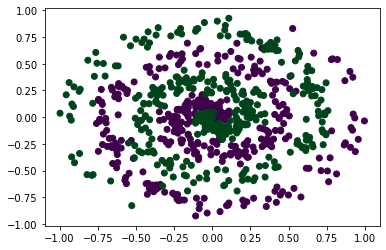

In [421]:
# plt.scatter(spirX[:,0],spirX[:,1], c=get_colors(colors, spirY))
plt.scatter(spirX[:,0],spirX[:,1], c=spirY, cmap=cmap)

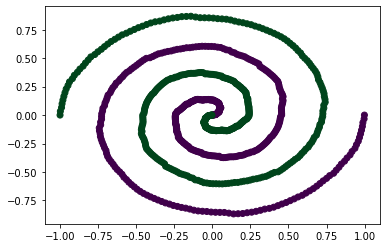

In [422]:
# no noise simulation
tempspirX, tempspirY = generate_spirals(750, K=2, noise=0, rng=1)
# plt.scatter(tempspirX[:,0],tempspirX[:,1], c=get_colors(colors, tempspirY))
plt.scatter(tempspirX[:,0],tempspirX[:,1], c=tempspirY, cmap=cmap)

In [295]:
filename = 'clf/dataset.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f, encoding='bytes')

    gausX, gausY, new_gausX, new_gausY = dataset[0]
    unifX, unifY, new_unifX, new_unifY = dataset[1]
    spirX, spirY, new_spirX, new_spirY = dataset[2]
    gausRX, gausRY, new_gausRX, new_gausRY = dataset[3]
    gausSX, gausSY, new_gausSX, new_gausSY = dataset[4]    

    print('[', filename, '] loaded')

else: 
    print('creating new datasets..')
    sTime = datetime.now()
    
    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        temp = []
        for i in range(5):
            temp.append(select_dataset(i))
        pickle.dump(temp, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

[ clf/dataset.pickle ] loaded


In [423]:
filename = 'clf/Cdataset.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f, encoding='bytes')

    CgausX, CgausY, Cnew_gausX, Cnew_gausY = dataset[0]
    CunifX, CunifY, Cnew_unifX, Cnew_unifY = dataset[1]
    spirX, spirY, new_spirX, new_spirY = dataset[2]
    CgausRX, CgausRY, Cnew_gausRX, Cnew_gausRY = dataset[3]
    CgausSX, CgausSY, Cnew_gausSX, Cnew_gausSY = dataset[4]    

    print('[', filename, '] loaded')

else: 
    print('creating new datasets..')
    sTime = datetime.now()
    
    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        temp = []
        for i in range(5):
            temp.append(select_dataset(i, cc=True))
        pickle.dump(temp, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

creating new datasets..
completed after 0 seconds
saved as [ clf/Cdataset.pickle ]


## training algorithms

In [284]:
def train_algo(dset, enable=[1,1,1,1,1,1], savefile=True):
    
    def tune_param(clf, param, name):
        
        model=GridSearchCV(clf, param_grid=param, return_train_score=True, cv=20)
        model.fit(train_X, train_y)
        
        print(name + " INFO:")
        print("Best hyper paramters:",model.best_params_)
        print("Best accuracy value: ",model.best_score_)
        
        clf.set_params(**model.best_params_)
        clf.fit(train_X, train_y)
        print("prediction score: ", model.score(test_X, test_y))
        print(clf)
        
        # plot_posterior(X, y, newX, newy, clf, name, savefile)
        
        # xx, yy, Z, new_p, zz = plot_decision_boundaries(X, y ,clf, h=h)
        return clf
    
    # prefix = ['Gaus_XOR_', 'spiral_']
    # mods = [prefix[dset] + i for i in mod_n]
    post = []

    train_X, train_y, test_X, test_y = select_dataset(dset)

    ##### KNN #####
    
    if enable[0] == 1:
        tuned_param=[{'n_neighbors':[3,5,7], 'leaf_size':range(10,100,10)},
                     {'n_neighbors':[3,5,7], 'leaf_size':range(10,100,10)},
                     {'n_neighbors':[7]},
                     {'n_neighbors':[3,5,7], 'leaf_size':range(10,100,10)},
                     {'n_neighbors':[3,5,7], 'leaf_size':range(10,100,10)}]
        temp = tune_param(KNeighborsClassifier(), tuned_param[dset], mods[0])
        post.append(temp)

    ##### SVC #####
    
    if enable[1] == 1:
        tuned_param=[{'gamma':['auto'], 'probability':[True]},
                     {'gamma':['auto'], 'probability':[True]},
                     {'C':np.linspace(1,10,10), 'probability':[True]},
                     {'gamma':['auto'], 'probability':[True]},
                     {'gamma':['auto'], 'probability':[True]}]
        temp = tune_param(svm.SVC(), tuned_param[dset], mods[1])
        post.append(temp)
                   
    ##### nuSVC #####
    
    if enable[2] == 1:
        tuned_param=[{'gamma':['auto'], 'probability':[True]},
                     {'gamma':['auto'], 'probability':[True]},
                     {'probability':[True]},
                     {'gamma':['auto'], 'probability':[True]},
                     {'gamma':['auto'], 'probability':[True]}]
        temp = tune_param(svm.NuSVC(), tuned_param[dset], mods[2])
        post.append(temp)

    ##### xgbooster #####
    
    if enable[3] == 1:
        tuned_param=[ {'n_jobs':[-1], 'learning_rate':np.linspace(0,1,20),'n_estimators':[64,128,256], 
                     'gamma': [0], 'objective':['binary:logistic']},
                     {'n_jobs':[-1], 'learning_rate':np.linspace(0,1,20),'n_estimators':[64,128,256], 
                     'gamma': [0], 'objective':['binary:logistic']},
                    {'n_jobs':[-1], 'learning_rate':np.linspace(0,1,20),'n_estimators':[64,128,256], 
                    'gamma': [0]},
                    {'n_jobs':[-1], 'learning_rate':np.linspace(0,1,20),'n_estimators':[64,128,256], 
                     'gamma': [0], 'objective':['binary:logistic']},
                     {'n_jobs':[-1], 'learning_rate':np.linspace(0,1,20),'n_estimators':[64,128,256], 
                     'gamma': [0], 'objective':['binary:logistic']}]
        temp = tune_param(xgb.XGBClassifier(objective='binary:logistic'), 
                             tuned_param[dset], mods[3])
        post.append(temp)
    
    #### mlp #####
    
    if enable[4] == 1:
        tuned_param=[{'alpha':[0], 'max_iter':[7000], 'hidden_layer_sizes':[100], 'learning_rate_init':[0.0001]},
                    {'alpha':[0], 'max_iter':[7000], 'hidden_layer_sizes':[100], 'learning_rate_init':[0.0001]},
                    {'alpha':[0], 'max_iter':[10000], 'activation':['logistic', 'relu'], 'learning_rate_init':[0.0001], 'solver': ['lbfgs']},
                    {'alpha':[0], 'max_iter':[7000], 'hidden_layer_sizes':[100], 'learning_rate_init':[0.0001]},
                    {'alpha':[0], 'max_iter':[7000], 'hidden_layer_sizes':[100], 'learning_rate_init':[0.0001]}]
        temp = tune_param(MLPClassifier(), tuned_param[dset], mods[4])
        post.append(temp)

    #### RF #####
    
    if enable[5] == 1:
        tuned_param=[{'max_depth':range(1,11),'n_estimators':[64,128,256]}, #range(1,11)
                    {'max_depth':range(1,11),'n_estimators':[64,128,256]}, #range(1,11)
                    {'max_depth':range(10,20,2),'n_estimators':[64,128,256]},
                    {'max_depth':range(1,11),'n_estimators':[64,128,256]},
                    {'max_depth':range(1,11),'n_estimators':[64,128,256]}] #range(7,11)
        temp = tune_param(RandomForestClassifier(n_jobs=-1), 
                   tuned_param[dset], mods[5])
        post.append(temp)

    qda = QuadraticDiscriminantAnalysis()
    qda.fit(train_X,train_y)
    post.append(qda)
    
    return post
    # plot_posterior(X, y, newX, newy, post, mods, savefile, h=h)


In [487]:
def select_clf(dset=0, cc=False):
    if cc:
        if dset == 0:
            return Cgaus_clf
        elif dset == 1:
            return Cunif_clf
        elif dset == 2:
            return Cspirl_clf
        elif dset == 3:
            return CgausR_clf
        elif dset == 4:
            return CgausS_clf
        else:
            print ("ERROR: CLASSIFIER DOES NOT EXIST")
            return      

    else: 
        if dset == 0:
            return gaus_clf
        elif dset == 1:
            return unif_clf
        elif dset == 2:
            return spirl_clf
        elif dset == 3:
            return gausR_clf
        elif dset == 4:
            return gausS_clf
        else:
            print ("ERROR: CLASSIFIER DOES NOT EXIST")
            return   

In [126]:
def hellinger(p, q):
    '''
    Mean hellinger distance between two discrete distributions.
    p: array of probability
    q: array of probability
    '''
    try:
        # return np.sqrt(np.mean((np.sqrt(p) - np.sqrt(q)) ** 2))/ np.sqrt(2)
        # return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))/ np.sqrt(2)
        return np.mean(np.sqrt((np.sqrt(p) - np.sqrt(q)) ** 2)/ np.sqrt(2))

    except Exception:
        print("Error: posterior size mismatch")


# Validation of hellingner distance by implementation from gensim package

# import gensim
# from numpy.linalg import norm
# from scipy.integrate import quad
# from scipy import stats

# gensim.matutils.hellinger(gaus_post[0][0:], gaus_post[1][0:])

def hellinger_explicit(p, q):

    try:
        # deltaP = np.zeros(len(px))
        temp = []

        # for i in range(len(p)):
        #     deltaP[i] = np.sqrt(np.sum((np.sqrt(p[i]) - np.sqrt(q[i])) ** 2)) / np.sqrt(2)
        #     # hellinger(p[i], q[i])

        for p_i, q_i in zip(p, q):
            temp.append((np.sqrt(p_i) - np.sqrt(q_i)) ** 2)

        # print (np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2), np.sqrt( np.sum( temp ) ) / np.sqrt(2))

        return np.mean( np.sqrt( temp ) / np.sqrt(2) )

        # return deltaP

    except Exception:
        print("Error: posterior size mismatch")

def hellinger_cont(p,q):
    '''
    Hellinger distance for continuous probability distributions
    '''

    f = scipy.stats.gaussian_kde(p)
    g = scipy.stats.gaussian_kde(q)

    def integrand(x):
        return (f(x)**0.5 - g(x)**0.5)**2

    ans, err = quad(integrand, -np.inf, np.inf)
    return f, g, ans / 2

begin training..


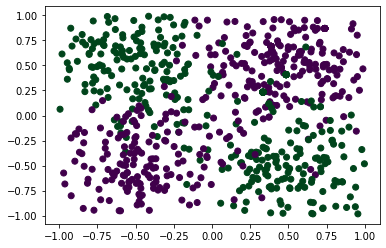

KNN INFO:
Best hyper paramters: {'leaf_size': 10, 'n_neighbors': 5}
Best accuracy value:  0.8803342816500711
prediction score:  0.8186666666666667
KNeighborsClassifier(leaf_size=10)
SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8105974395448079
prediction score:  0.8346666666666667
SVC(gamma='auto', probability=True)
nuSVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8105618776671408
prediction score:  0.836
NuSVC(gamma='auto', probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.05263157894736842, 'n_estimators': 256, 'n_jobs': -1, 'objective': 'binary:logistic'}
Best accuracy value:  0.8719772403982929
prediction score:  0.8226666666666667
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
             

In [283]:
filename = 'clf/clf_Gaus_XOR.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        gaus_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    gaus_clf = train_algo(0)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(gaus_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

In [285]:
filename = 'clf/clf_Gaus_RXOR.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        gausR_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    gausR_clf = train_algo(3)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(gausR_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

begin training..
KNN INFO:
Best hyper paramters: {'leaf_size': 10, 'n_neighbors': 5}
Best accuracy value:  0.8749288762446659
prediction score:  0.8346666666666667
KNeighborsClassifier(leaf_size=10)
SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8559032716927453
prediction score:  0.84
SVC(gamma='auto', probability=True)
nuSVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8557610241820768
prediction score:  0.8373333333333334
NuSVC(gamma='auto', probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.10526315789473684, 'n_estimators': 64, 'n_jobs': -1, 'objective': 'binary:logistic'}
Best accuracy value:  0.8773826458036986
prediction score:  0.804
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
           

In [286]:
filename = 'clf/clf_Gaus_SXOR.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        gausS_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    gausS_clf = train_algo(4)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(gausS_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

begin training..
KNN INFO:
Best hyper paramters: {'leaf_size': 10, 'n_neighbors': 3}
Best accuracy value:  1.0
prediction score:  0.9933333333333333
KNeighborsClassifier(leaf_size=10, n_neighbors=3)
SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  1.0
prediction score:  0.9946666666666667
SVC(gamma='auto', probability=True)
nuSVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  1.0
prediction score:  0.9933333333333333
NuSVC(gamma='auto', probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.10526315789473684, 'n_estimators': 128, 'n_jobs': -1, 'objective': 'binary:logistic'}
Best accuracy value:  1.0
prediction score:  0.9946666666666667
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=

In [287]:
filename = 'clf/clf_Unif_XOR.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        unif_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    unif_clf = train_algo(1)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(unif_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

begin training..
KNN INFO:
Best hyper paramters: {'leaf_size': 10, 'n_neighbors': 7}
Best accuracy value:  0.9734352773826457
prediction score:  0.9893333333333333
KNeighborsClassifier(leaf_size=10, n_neighbors=7)
SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.9558321479374111
prediction score:  0.9853333333333333
SVC(gamma='auto', probability=True)
nuSVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.9504267425320057
prediction score:  0.9906666666666667
NuSVC(gamma='auto', probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.05263157894736842, 'n_estimators': 64, 'n_jobs': -1, 'objective': 'binary:logistic'}
Best accuracy value:  1.0
prediction score:  1.0
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',

In [288]:
filename = 'clf/clf_Spiral.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        spirl_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    spirl_clf = train_algo(2)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(spirl_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

begin training..
KNN INFO:
Best hyper paramters: {'n_neighbors': 7}
Best accuracy value:  0.9316500711237555
prediction score:  0.464
KNeighborsClassifier(n_neighbors=7)
SVC INFO:
Best hyper paramters: {'C': 10.0, 'probability': True}
Best accuracy value:  0.42055476529160735
prediction score:  0.4026666666666667
SVC(C=10.0, probability=True)
nuSVC INFO:
Best hyper paramters: {'probability': True}
Best accuracy value:  0.7312944523470839
prediction score:  0.388
NuSVC(probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.10526315789473684, 'n_estimators': 256, 'n_jobs': -1}
Best accuracy value:  0.9037695590327172
prediction score:  0.5293333333333333
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.10526315789473684, max_delta_step=0, max_depth=6,
              min_c

## Circular bbox training

In [424]:
filename = 'clf/clf_CGaus_XOR.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        Cgaus_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    Cgaus_clf = train_algo(0)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(Cgaus_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

begin training..
KNN INFO:
Best hyper paramters: {'leaf_size': 10, 'n_neighbors': 7}
Best accuracy value:  0.8477951635846372
prediction score:  0.8546666666666667
KNeighborsClassifier(leaf_size=10, n_neighbors=7)
SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8116642958748221
prediction score:  0.8333333333333334
SVC(gamma='auto', probability=True)
nuSVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8129445234708392
prediction score:  0.832
NuSVC(gamma='auto', probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.3684210526315789, 'n_estimators': 64, 'n_jobs': -1, 'objective': 'binary:logistic'}
Best accuracy value:  0.8397226173541963
prediction score:  0.8546666666666667
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction

In [426]:
filename = 'clf/clf_CUnif_XOR.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        Cunif_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    Cunif_clf = train_algo(1)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(Cunif_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

begin training..
KNN INFO:
Best hyper paramters: {'leaf_size': 10, 'n_neighbors': 5}
Best accuracy value:  0.9693812233285917
prediction score:  0.9733333333333334
KNeighborsClassifier(leaf_size=10)
SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.9469416785206258
prediction score:  0.9653333333333334
SVC(gamma='auto', probability=True)
nuSVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.9243954480796587
prediction score:  0.9466666666666667
NuSVC(gamma='auto', probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.05263157894736842, 'n_estimators': 128, 'n_jobs': -1, 'objective': 'binary:logistic'}
Best accuracy value:  0.9960170697012802
prediction score:  0.9986666666666667
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction

In [425]:
filename = 'clf/clf_CSpiral.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        Cspirl_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    Cspirl_clf = train_algo(2)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(Cspirl_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

begin training..
KNN INFO:
Best hyper paramters: {'n_neighbors': 7}
Best accuracy value:  0.9197012802275962
prediction score:  0.5333333333333333
KNeighborsClassifier(n_neighbors=7)
SVC INFO:
Best hyper paramters: {'C': 10.0, 'probability': True}
Best accuracy value:  0.40590327169274537
prediction score:  0.5013333333333333
SVC(C=10.0, probability=True)
nuSVC INFO:
Best hyper paramters: {'probability': True}
Best accuracy value:  0.7436344238975818
prediction score:  0.43066666666666664
NuSVC(probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.21052631578947367, 'n_estimators': 256, 'n_jobs': -1}
Best accuracy value:  0.9038406827880513
prediction score:  0.5386666666666666
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.21052631578947367, max_delta_step=0, max_d

In [428]:
filename = 'clf/clf_CGaus_RXOR.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        CgausR_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    CgausR_clf = train_algo(3)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(CgausR_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

begin training..
KNN INFO:
Best hyper paramters: {'leaf_size': 10, 'n_neighbors': 5}
Best accuracy value:  0.8416073968705549
prediction score:  0.8026666666666666
KNeighborsClassifier(leaf_size=10)
SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.7879089615931723
prediction score:  0.72
SVC(gamma='auto', probability=True)
nuSVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  0.8108108108108109
prediction score:  0.676
NuSVC(gamma='auto', probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.05263157894736842, 'n_estimators': 64, 'n_jobs': -1, 'objective': 'binary:logistic'}
Best accuracy value:  0.8614864864864865
prediction score:  0.7146666666666667
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
           

In [427]:
filename = 'clf/clf_CGaus_SXOR.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        CgausS_clf = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    print('begin training..')
    sTime = datetime.now()
    
    CgausS_clf = train_algo(4)

    if not os.path.isdir(CLFPATH):
        os.makedirs(CLFPATH)

    with open(filename, 'wb') as f:
        pickle.dump(CgausS_clf, f)

    deltaT = datetime.now() - sTime
    print('completed after ' + str(deltaT.seconds) + ' seconds')
    print('saved as [', filename, ']')

begin training..
KNN INFO:
Best hyper paramters: {'leaf_size': 10, 'n_neighbors': 3}
Best accuracy value:  1.0
prediction score:  0.9933333333333333
KNeighborsClassifier(leaf_size=10, n_neighbors=3)
SVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  1.0
prediction score:  0.9946666666666667
SVC(gamma='auto', probability=True)
nuSVC INFO:
Best hyper paramters: {'gamma': 'auto', 'probability': True}
Best accuracy value:  1.0
prediction score:  0.9933333333333333
NuSVC(gamma='auto', probability=True)
XGBoost INFO:
Best hyper paramters: {'gamma': 0, 'learning_rate': 0.10526315789473684, 'n_estimators': 128, 'n_jobs': -1, 'objective': 'binary:logistic'}
Best accuracy value:  1.0
prediction score:  0.9946666666666667
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=

In [132]:
with open('clf/20201021_trueSpiral_5k.pickle', 'rb') as f:
    newc11, newc12 = pickle.load(f, encoding='bytes')

## Calculate TRUE posterior with SQUARE bbox

In [463]:
h=0.01

# generate grid
uX = generate_mask(h=h)
uX0, uX1 = uX[:,0], uX[:,1]

# acquire true posterior
true_zz = []
# true XOR posterior by default
xx, yy, zz = true_xor(h=h)
true_zz.append(zz)
xx, yy, zz = true_Uxor(h=h)
true_zz.append(zz)
true_zz.append(normalize(newc11, newc12))
xx, yy, zz = true_xor(h=h, rotate=True)
true_zz.append(zz)
xx, yy, zz = true_xor(h=h, sig=0.1)
true_zz.append(zz)

## Calculate TRUE posterior with CIRCULAR bbox

In [464]:
h=0.01

# generate grid
uX = generate_mask(h=h)
uX0, uX1 = uX[:,0], uX[:,1]

# acquire true posterior
Ctrue_zz = []
# true XOR posterior by default
xx, yy, zz = true_xor(h=h, cc=True)
Ctrue_zz.append(zz)
xx, yy, zz = true_Uxor(h=h, cc=True)
Ctrue_zz.append(zz)
Ctrue_zz.append(normalize(newc11, newc12))
xx, yy, zz = true_xor(h=h, rotate=True, cc=True)
Ctrue_zz.append(zz)
xx, yy, zz = true_xor(h=h, sig=0.1, cc=True)
Ctrue_zz.append(zz)

## Calculate ESTIMATED posterior with SQUARE bbox

In [195]:
# acquire estimated posterior
post = []
dsetnum = len(data)

for j in range(dsetnum):
    
    clf = select_clf(j)

    post.append([])

    for i in clf:
        temp = None # for some reason, this is required for RXOR
        temp = i.predict_proba(uX)
        post[j].append(temp[:,1])

print(np.array(post).shape)

(5, 7, 160000)


## Calculate ESTIMATED posterior with CIRCULAR bbox

In [489]:
# acquire estimated posterior
Cpost = []
dsetnum = len(data)

for j in range(dsetnum):
    
    clf = select_clf(j, cc=True)

    Cpost.append([])

    for i in clf:
        temp = None # for some reason, this is required for RXOR
        temp = i.predict_proba(uX)
        Cpost[j].append(temp[:,1])

print(np.array(Cpost).shape)

(5, 7, 160000)


In [290]:
filename = 'clf/Hellinger4.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        OUT_hellinger, uX_inside, uX_outside = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    uX_outside = []
    uX_inside  = []
    OUT_hellinger = []

    # split inside and outside
    for i in range(len(uX)):

        if np.all([uX[i] > -1, uX[i] < 1]):
            uX_inside.append(uX[i].tolist())
        else:
            uX_outside.append(uX[i].tolist())

    uX_outside = np.array(uX_outside)

    for dat in range(len(data)):

        OUT_hellinger.append([])

        # calculate hellinger distance
        for i in range(len(post[0])):

            inner_trueP = np.zeros(len(uX_inside))
            inner_testP = np.zeros(len(uX_inside))
            outer_trueP = np.zeros(len(uX_outside))
            outer_testP = np.zeros(len(uX_outside))
            innermask = []
            outermask = []
            temp_OUT_hellinger = np.zeros(len(uX_outside))
            temp_IN_hellinger = np.zeros(len(uX_inside))
            c = 0
            cc = 0

            for ii, prob in enumerate(uX):
                if np.all([prob > -1, prob < 1]):
                    inner_trueP[c] = true_zz[dat][ii]    
                    inner_testP[c] = post[dat][i][ii]
                    temp_IN_hellinger[c] = hellinger(inner_trueP[c], inner_testP[c])
                    innermask.append(prob)
                    c += 1
                else:
                    outer_trueP[cc] = true_zz[dat][ii]    
                    outer_testP[cc] = post[dat][i][ii]
                    temp_OUT_hellinger[cc] = hellinger(outer_trueP[cc], outer_testP[cc])
                    outermask.append(prob)
                    cc += 1
            
            OUT_hellinger[dat].append(temp_OUT_hellinger)
        
        with open(filename, 'wb') as f:
             pickle.dump([OUT_hellinger, uX_inside, uX_outside], f)

    # return OUT_hellinger

In [476]:
filename = 'clf/CHellinger.pickle'

if path.exists(filename):
    with open(filename, 'rb') as f:
        COUT_hellinger, CuX_inside, CuX_outside = pickle.load(f, encoding='bytes')
    print('[', filename, '] loaded')

else: 
    CuX_outside = []
    CuX_inside  = []
    COUT_hellinger = []

    # split inside and outside
    for i in range(len(uX)):

        if np.sqrt((uX[i]**2).sum(axis=0)) < 1:  #np.all([uX[i] > -1, uX[i] < 1]):
            CuX_inside.append(uX[i].tolist())
        else:
            CuX_outside.append(uX[i].tolist())

    CuX_outside = np.array(CuX_outside)

    for dat in range(len(data)):

        COUT_hellinger.append([])

        # calculate hellinger distance
        for i in range(len(Cpost[0])):

            inner_trueP = np.zeros(len(CuX_inside))
            inner_testP = np.zeros(len(CuX_inside))
            outer_trueP = np.zeros(len(CuX_outside))
            outer_testP = np.zeros(len(CuX_outside))
            innermask = []
            outermask = []
            temp_OUT_hellinger = np.zeros(len(CuX_outside))
            temp_IN_hellinger  = np.zeros(len(CuX_inside))
            c = 0
            cc = 0

            for ii, prob in enumerate(uX):
                if np.sqrt((prob**2).sum(axis=0)) < 1: #np.all([prob > -1, prob < 1]):
                    inner_trueP[c] = Ctrue_zz[dat][ii]    
                    inner_testP[c] = Cpost[dat][i][ii]
                    temp_IN_hellinger[c] = hellinger(inner_trueP[c], inner_testP[c])
                    innermask.append(prob)
                    c += 1
                else:
                    outer_trueP[cc] = Ctrue_zz[dat][ii]    
                    outer_testP[cc] = Cpost[dat][i][ii]
                    temp_OUT_hellinger[cc] = hellinger(outer_trueP[cc], outer_testP[cc])
                    outermask.append(prob)
                    cc += 1
            
            COUT_hellinger[dat].append(temp_OUT_hellinger)
        
        with open(filename, 'wb') as f:
             pickle.dump([COUT_hellinger, CuX_inside, CuX_outside], f)

    # return OUT_hellinger

In [492]:
def plot_posterior(dset=0, h=0.01, enable=[1,1,1,1], cc=False, savefile=True):

    # makes folder if not exists
    if not os.path.isdir(FILEPATH):
        os.makedirs(FILEPATH)

    dsetnum = len(data)

    X1, X2, y = [],[],[]

    for i in range(dsetnum):
        if cc:
            X, tempy, _, _ = select_dataset(i, cc=True)
        else:
            X, tempy, _, _ = select_dataset(i)
        y.append(tempy)
        X1.append(X[:,0])
        X2.append(X[:,1])
        # X1[i], X2[i] = , X[:,1]

    premax = round(X.max())
    postmax = round(uX0.max())

    prerng = (-premax,premax)
    postrng = (-postmax,postmax)
    clfname = mods.copy()

    md = 3 # model to be plotted as figure 3; [0,5]
    fsize = 15 # figure fontsize

    # cmap = 'RdBu_r'

    if enable[0] == 1:

        ################ TYPE 1 ################

        flen = dsetnum# figure size

        # fig, axs = plt.subplots(1,flen, figsize=(30,9))
        fig = plt.figure(figsize=(30,5))

        for i in range(dsetnum):
            axs = fig.add_subplot(1,flen,i+1)
            pcm = axs.scatter(X1[i], X2[i], c=get_colors(colors, y[i]), s=20)
            axs.add_patch(Rectangle(
                            (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))

            axs.set_title(data[i], fontsize=fsize)
            axs.set_xticks([])
            axs.set_yticks([])

            axs.set_xlim(np.multiply(postrng, 1))
            axs.set_ylim(np.multiply(postrng, 1)) 

        # plt.suptitle('Simulated Datasets', fontsize=25) 

        if savefile:
            plt.savefig('figs/' + str(datetime.today())[:10] + '_simulated_datasets_' + '(' + str(h) + ').png')

        fig = plt.figure(figsize=(30,4))

        for i in range(dsetnum):
            axs = fig.add_subplot(1,flen,i+1)
            pcm = axs.scatter(xx, yy, c=true_zz[i], cmap=cmap, s=5)
            axs.add_patch(Rectangle(
                            (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))
            # fig.colorbar(pcm, ax=axs)  

            axs.set_title(data[i], fontsize=fsize)
            axs.set_xticks([])
            axs.set_yticks([])
            axs.set_xlim(np.multiply(postrng, 1))
            axs.set_ylim(np.multiply(postrng, 1)) 

        # plt.suptitle('True Posteriors', fontsize=25) 

        if savefile:
            plt.savefig('figs/' + str(datetime.today())[:10] + '_true_posteriors_' + '(' + str(h) + ').png')

        ################ END OF TYPE 1 ################

    if enable[1] == 1:

        ################ TYPE 2 ################

        # fig = plt.figure(figsize=(13,16))
        cnt = 0
        cnt2 = -1
        cnt3 = -1
        fig = plt.figure(figsize=(30,4*(dsetnum)))

        for j in range(dsetnum):
            # fig = plt.figure(figsize=(30,4))
            for i in range(len(post[0])+2):
                
                # i += 1
                # print(i)
                cnt += 1
                axs = fig.add_subplot(dsetnum,9,cnt)

                if cnt % 9 == 1:
                    cnt3 += 1
                    pcm = axs.scatter(X1[cnt3], X2[cnt3], c=get_colors(colors, y[cnt3]), s=10)
                elif cnt % 9 == 2:
                    cnt2 += 1
                    pcm = axs.scatter(xx, yy, c=true_zz[cnt2], cmap=cmap, s=5)
                else:
                    pcm = axs.scatter(uX0, uX1, c=post[j][i-2], cmap=cmap, s=5)

                axs.add_patch(Rectangle(
                                (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))
                # fig.colorbar(pcm, ax=axs)
                axs.set_xticks([])
                axs.set_yticks([])

                if i == 0:
                    axs.set_ylabel(data[j], fontsize=18)
                if j == 0 and i > 1:
                    axs.set_title(clfname[i-2], fontsize=fsize) 
                elif j == 0 and i == 0:
                    axs.set_title('Simulation Data', fontsize=fsize) 
                elif j == 0 and i == 1:
                    axs.set_title('True Posterior', fontsize=fsize) 

                # axs.set_xlim(np.multiply(postrng, 1))
                # axs.set_ylim(np.multiply(postrng, 1))  

        if savefile:
            plt.savefig('figs/' + str(datetime.today())[:10] + '_estimated_posterior_' + '(' + str(h) + ').png')

        ################ END OF TYPE 2 ################

    if enable[2] == 1:

        ################ TYPE 3 ################

            # cnt = 0
            # fig = plt.figure(figsize=(30,4*(dsetnum)))
            # # plt.suptitle('Mean Hellinger Distance', fontsize=25)

            # for j in range(dsetnum):

            #     for i in range(len(post[0])):
            #         cnt += 1
            #         axs = fig.add_subplot(dsetnum,7,cnt)
            #         axs.set_xticks([])
            #         axs.set_yticks([])
            #         pcm = axs.scatter(uX_outside[:,0], uX_outside[:,1], c=OUT_hellinger[j][i], cmap='binary', s=5)
            #         axs.add_patch(Rectangle(
            #                         (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False, hatch='/'))
            #         # fig.colorbar(pcm, ax=axs)  
            #         if i == 0:
            #             axs.set_ylabel(data[j], fontsize=18)
            #         if j == 0:
            #             axs.set_title(clfname[i], fontsize=fsize)

            #         axs.set_xlim(np.multiply(postrng, 1))
            #         axs.set_ylim(np.multiply(postrng, 1))  

            # if savefile:
            #     plt.savefig('figs/' + str(datetime.today())[:10] + '_hellinger_figures_' + '(' + str(h) + ').png')

        fig, axs = plt.subplots(2,2, figsize=(8,8))

        axs[0,0].set_title('Gaussian XOR', fontsize=fsize) 
        axs[0,0].set_xticks([])
        axs[0,0].set_yticks([])
        axs[0,0].set_xlim(np.multiply(postrng, 1))
        axs[0,0].set_ylim(np.multiply(postrng, 1)) 
        axs[0,0].scatter(X1[0], X2[0], c=get_colors(colors, y[0]), s=20)
        axs[0,0].add_patch(Rectangle(
                        (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))

        axs[0,1].set_title('True Posterior', fontsize=fsize) 
        axs[0,1].set_xticks([])
        axs[0,1].set_yticks([])
        axs[0,1].set_xlim(np.multiply(postrng, 1))
        axs[0,1].set_ylim(np.multiply(postrng, 1)) 
        axs[0,1].scatter(xx, yy, c=true_zz[0], cmap=cmap, s=1)
        axs[0,1].add_patch(Rectangle(
                        (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))

        axs[1,0].set_title('RF', fontsize=fsize) 
        axs[1,0].set_xticks([])
        axs[1,0].set_yticks([])
        axs[1,0].set_xlim(np.multiply(postrng, 1))
        axs[1,0].set_ylim(np.multiply(postrng, 1)) 
        axs[1,0].scatter(uX0, uX1, c=post[0][5], cmap=cmap, s=5)
        axs[1,0].add_patch(Rectangle(
                        (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))

        axs[1,1].set_title('DN', fontsize=fsize) 
        axs[1,1].set_xticks([])
        axs[1,1].set_yticks([])
        axs[1,1].set_xlim(np.multiply(postrng, 1))
        axs[1,1].set_ylim(np.multiply(postrng, 1)) 
        axs[1,1].scatter(uX0, uX1, c=post[0][4], cmap=cmap, s=5)
        axs[1,1].add_patch(Rectangle(
                        (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))

        if savefile:
            plt.savefig('updated_figure.png')
    

        ################ END OF TYPE 3 ################        
    
    if enable[3] == 1:

        ################ TYPE 4 ################

            row = 2
            col = 8#+1
            
            # plt.suptitle('Mean Hellinger Distance', fontsize=25)

            # dsetnum = 1

            for j in range(dsetnum):

                cnt = 0
                
                # fig = plt.figure()           
                fig = plt.figure(figsize=(4*col,4*row))

                ax = fig.add_subplot(111)
                ax.set_xticks([])
                ax.set_yticks([])

                ax.spines['top'].set_color('none')
                ax.spines['bottom'].set_color('none')
                ax.spines['left'].set_color('none')
                ax.spines['right'].set_color('none')

                ax.set_ylabel(data[j], fontsize=18)

                axlist = []
                
                for k in range(row):
                    for i in range(col):
                        cnt += 1
                        # if k == 0 and i == 0:
                        #     axs = fig.add_subplot(row,col,cnt)
                        #     # fig.ylabel(data[j], fontsize=18)
                        # else:
                        axs = fig.add_subplot(row,col,cnt)#, sharey=axs)
                        axlist.append(axs)

                        axs.set_xticks([])
                        axs.set_yticks([])

                        # simulation dataset
                        if cnt == 1:
                            pcm = axs.scatter(X1[j], X2[j], c=y[j], cmap=cmap, s=20) #c=get_colors(colors, y[j]), 
                            if cc:
                                axs.add_patch(Circle((0,0), radius=1, linewidth=2, edgecolor='k', fill=False))
                            else:
                                axs.add_patch(Rectangle(
                                            (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))                                            
                        # true posterior
                        elif cnt == 9:  
                            if j == 2:
                                a, b, c, d, e, f, g = pdf_spiral(500000, noise=0.9, K=2)
                                pcm = axs.scatter(a[:,0],a[:,1], c=c, cmap=cmap, s=0.1)       
                                if cc:
                                    axs.add_patch(Circle((0,0), radius=1, linewidth=2, edgecolor='k', fill=False))                      
                                else:
                                    axs.add_patch(Rectangle(
                                                (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))                               
                            else:    
                                if cc:
                                    pcm = axs.scatter(xx, yy, c=Ctrue_zz[j], cmap=cmap, s=1)
                                    axs.add_patch(Circle((0,0), radius=1, linewidth=2, edgecolor='k', fill=False))
                                else:
                                    pcm = axs.scatter(xx, yy, c=true_zz[j], cmap=cmap, s=1)
                                    axs.add_patch(Rectangle(
                                                (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))
                        # estimated posterior
                        elif cnt > 1 and cnt < 9:
                            if cc:
                                pcm = axs.scatter(uX0, uX1, c=Cpost[j][i-1], cmap=cmap, s=1)
                                axs.add_patch(Circle((0,0), radius=1, linewidth=2, edgecolor='k', fill=False))
                            else:                    
                                pcm = axs.scatter(uX0, uX1, c=post[j][i-1], cmap=cmap, s=1)
                                axs.add_patch(Rectangle(
                                                (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False))
                        # colorbar
                        # elif i == col-1:
                        #     # fig2 = pl.figure(figsize=(0.5, 4))
                        #     axs = plt.imshow([[0,1]], cmap='RdBu_r')
                        #     plt.gca().set_visible(False)
                        #     cax = plt.axes([0.1, 0.2, 0.8, 0.6])
                        #     plt.colorbar(orientation="vertical", cax=cax)

                        # hellinger
                        else:     
                            if cc:
                                pcm = axs.scatter(CuX_outside[:,0], CuX_outside[:,1], c=COUT_hellinger[j][i-1], cmap='binary', s=5)
                                axs.add_patch(Circle((0,0), radius=1, linewidth=2, edgecolor='k', fill=False, hatch='/'))
                                temptitle = 'Mean Distance:' + str(round(COUT_hellinger[j][i-1].mean(),2))
                                axs.set_title(temptitle, fontsize=fsize)
                            else:
                                pcm = axs.scatter(uX_outside[:,0], uX_outside[:,1], c=OUT_hellinger[j][i-1], cmap='binary', s=5)
                                axs.add_patch(Rectangle(
                                                (-1,-1), 2, 2, linewidth=2, edgecolor='k', fill=False, hatch='/'))
                                temptitle = 'Mean Distance:' + str(round(OUT_hellinger[j][i-1].mean(),2))
                                axs.set_title(temptitle, fontsize=fsize)
                        # fig.colorbar(pcm, ax=axs)  
                        if k == 0 and i == 0:                            
                            axs.set_title('Simulation Data', fontsize=fsize)
                            axs.set_xticks([])
                            axs.set_yticks([])

                        if k == 1 and i == 0:                    
                            axs.set_title('True Posterior', fontsize=fsize)
                            axs.set_xticks([])
                            axs.set_yticks([])

                        # if k == 1 and i > 0:
                        #     templabel = 'Mean Hellinger Distance' + clfname[i-1]
                        #     axs.set_title(templabel, fontsize=18)

                        if k == 0 and i == 1:
                            axs.set_ylabel('Estimated Posterior', fontsize=18)
                            axs.set_yticks([])

                        if k == 1 and i == 1:
                            axs.set_ylabel('Point-wise Hellinger', fontsize=18)
                            axs.set_yticks([])

                        if k == 0 and i > 0 and i < col:
                            axs.set_title(clfname[i-1], fontsize=fsize)

                        # if i == col-1:
                        #     pass
                        # else:
                        axs.set_xlim(np.multiply(postrng, 1))
                        axs.set_ylim(np.multiply(postrng, 1))  
                    # cbar = fig.colorbar(pcm, ax=axlist,shrink=0.5)
                    # cbar.set_ticks([0,1])

                if savefile:
                    if cc:
                        path = 'figs/' + str(datetime.today())[:10] + '_' + data[j] + '_Cfigures.png'# + '(' + str(h) + ')'
                    else:
                        path = 'figs/' + str(datetime.today())[:10] + '_' + data[j] + '_figures.png'# + '(' + str(h) + ')'
                    plt.tight_layout(pad=2)
                    plt.savefig(path, bbox='tight')

                plt.show()               

            # plt.subplots(2,2)


        ################ END OF TYPE 4 ################  

    # plt.tight_layout()
    # plt.show()

    # return inner_testP, inner_trueP, outer_testP, outer_trueP, np.array(innermask), np.array(outermask)

    # print (uX, set(px[:,1] == uX[:,1]), true_zz, len(post), inner_trueP, inner_testP)

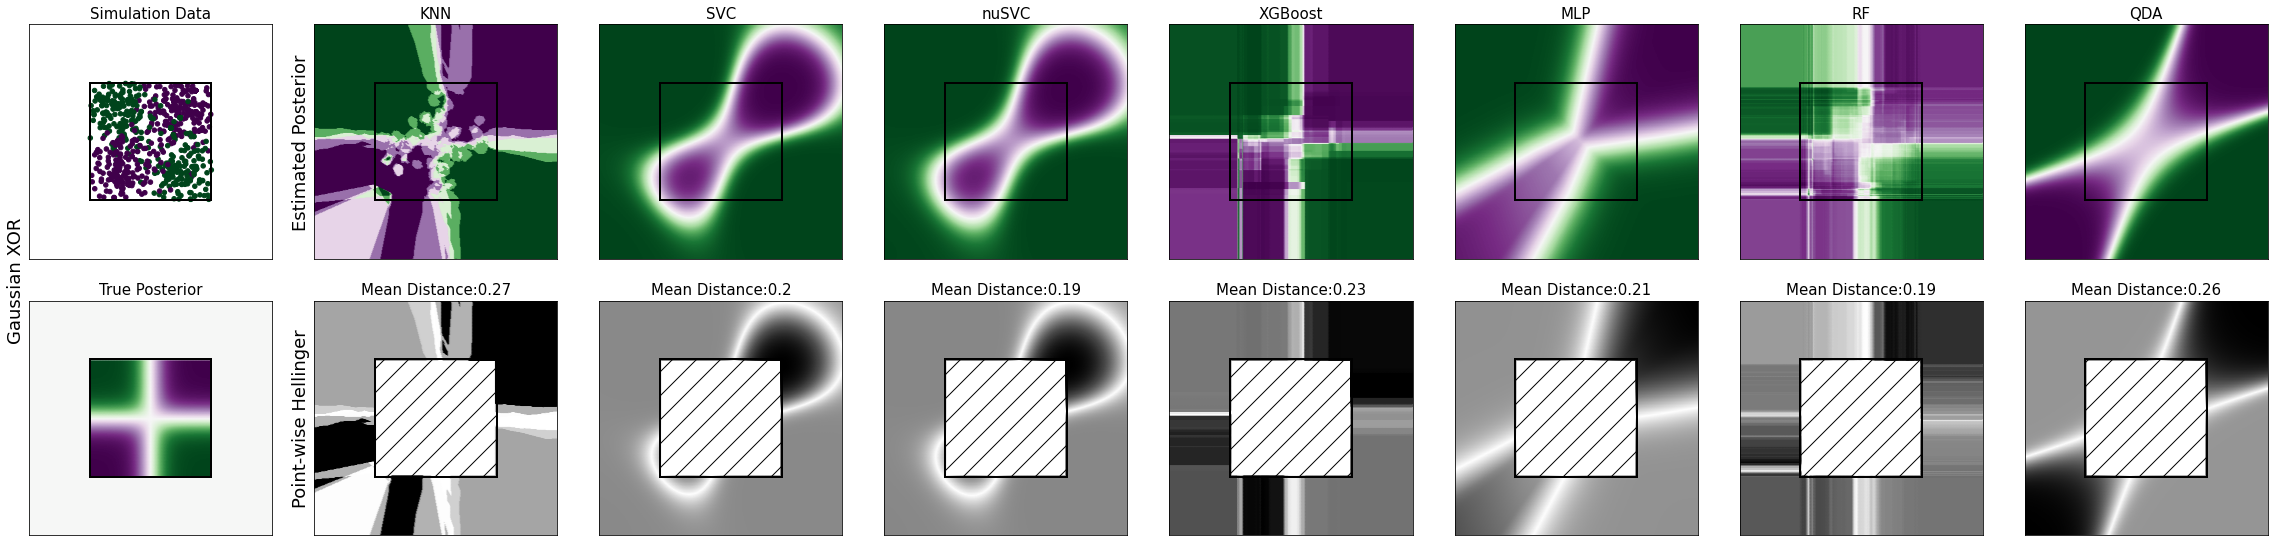

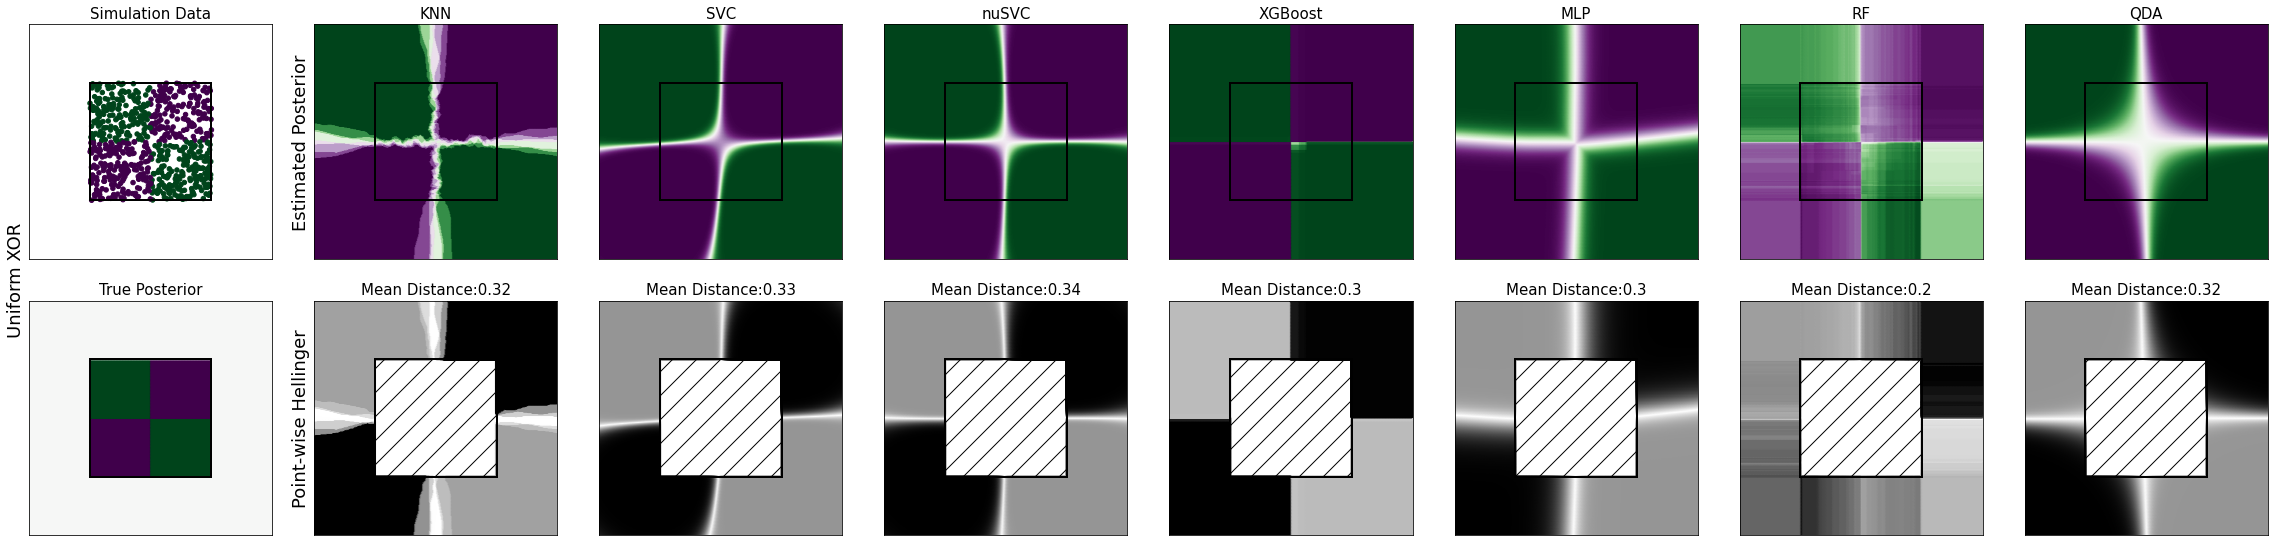

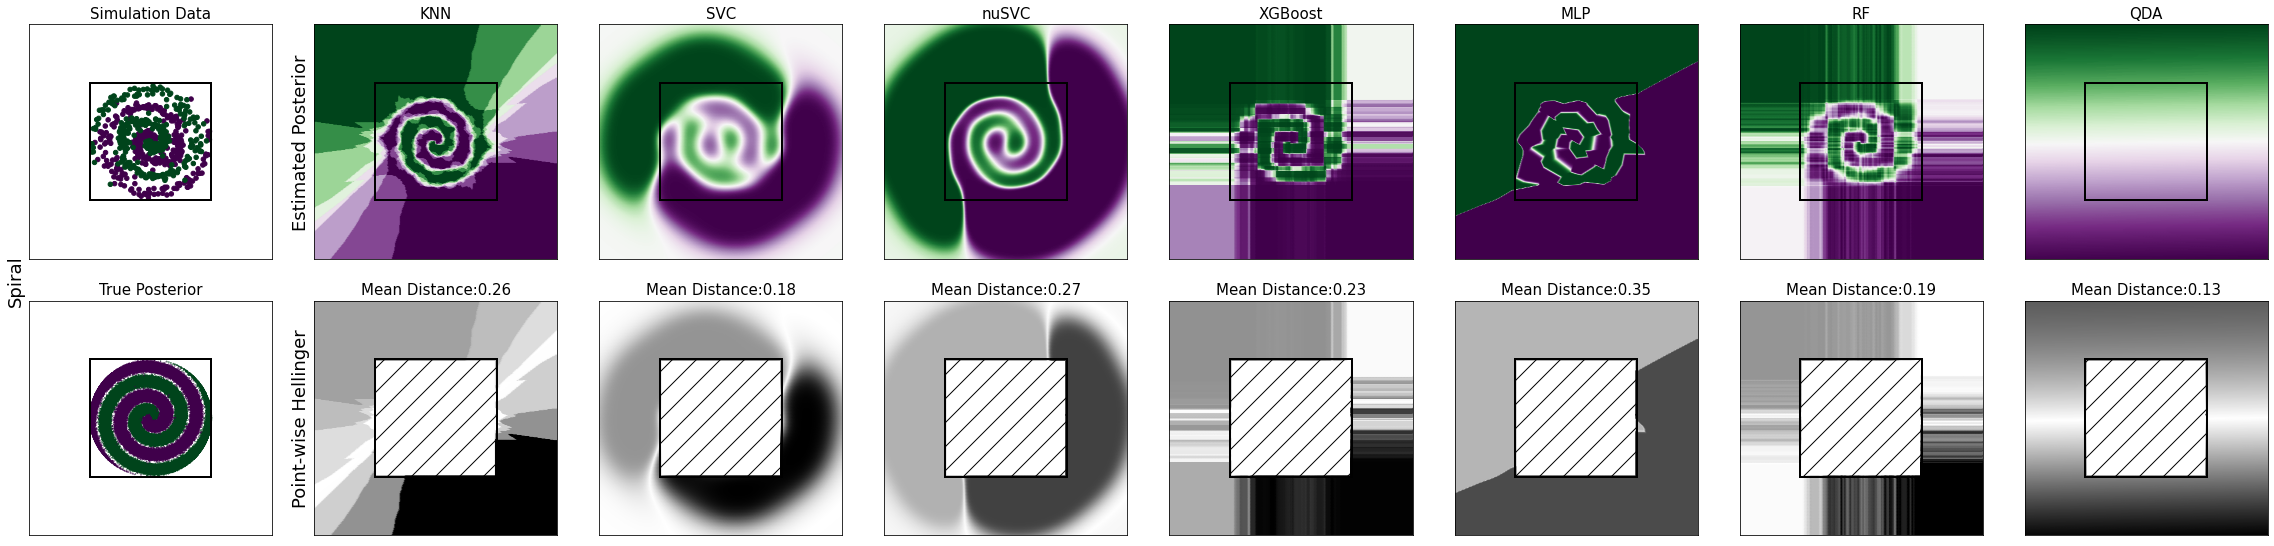

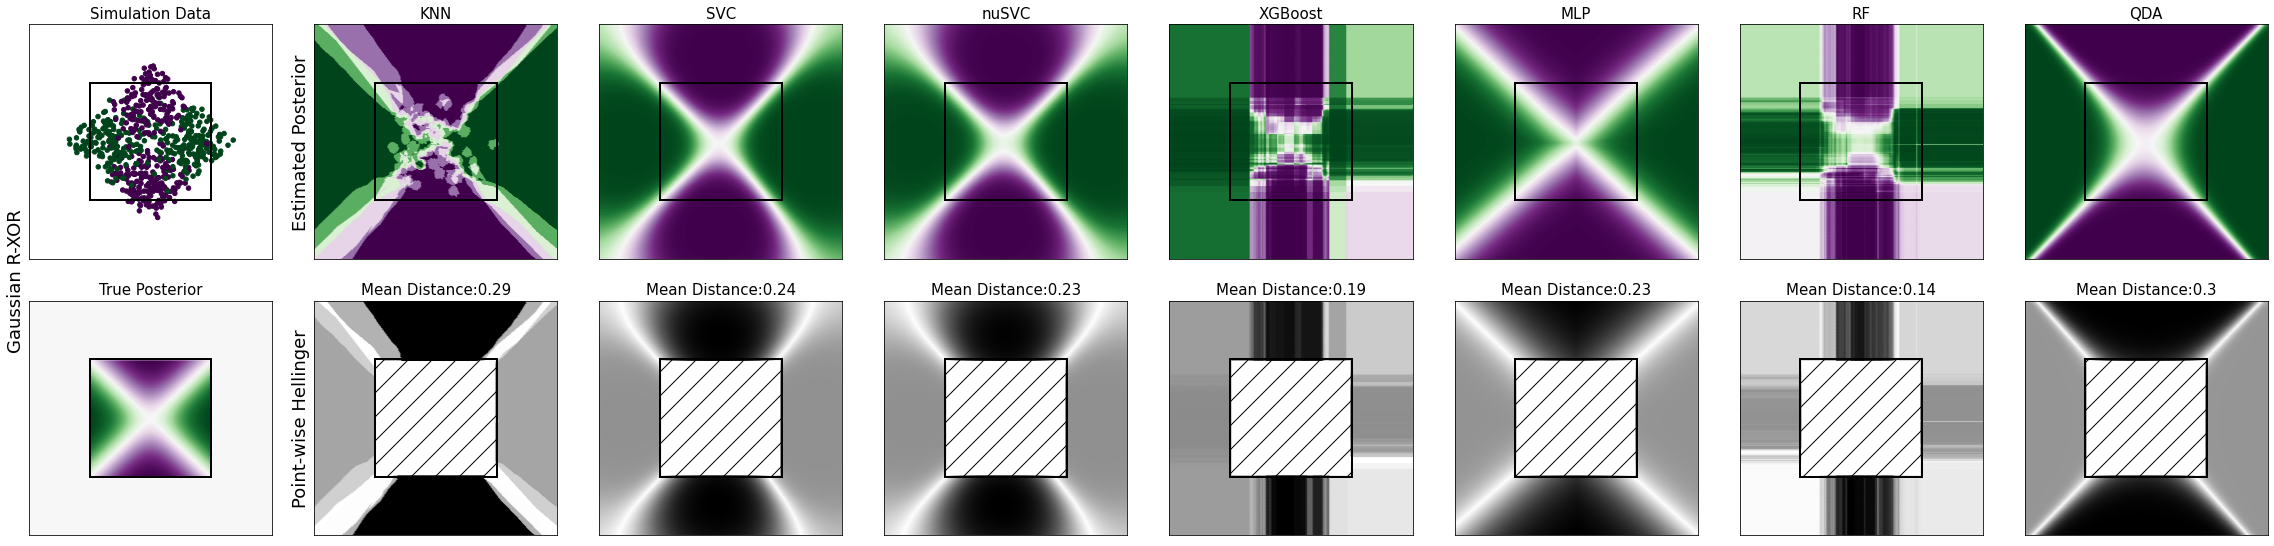

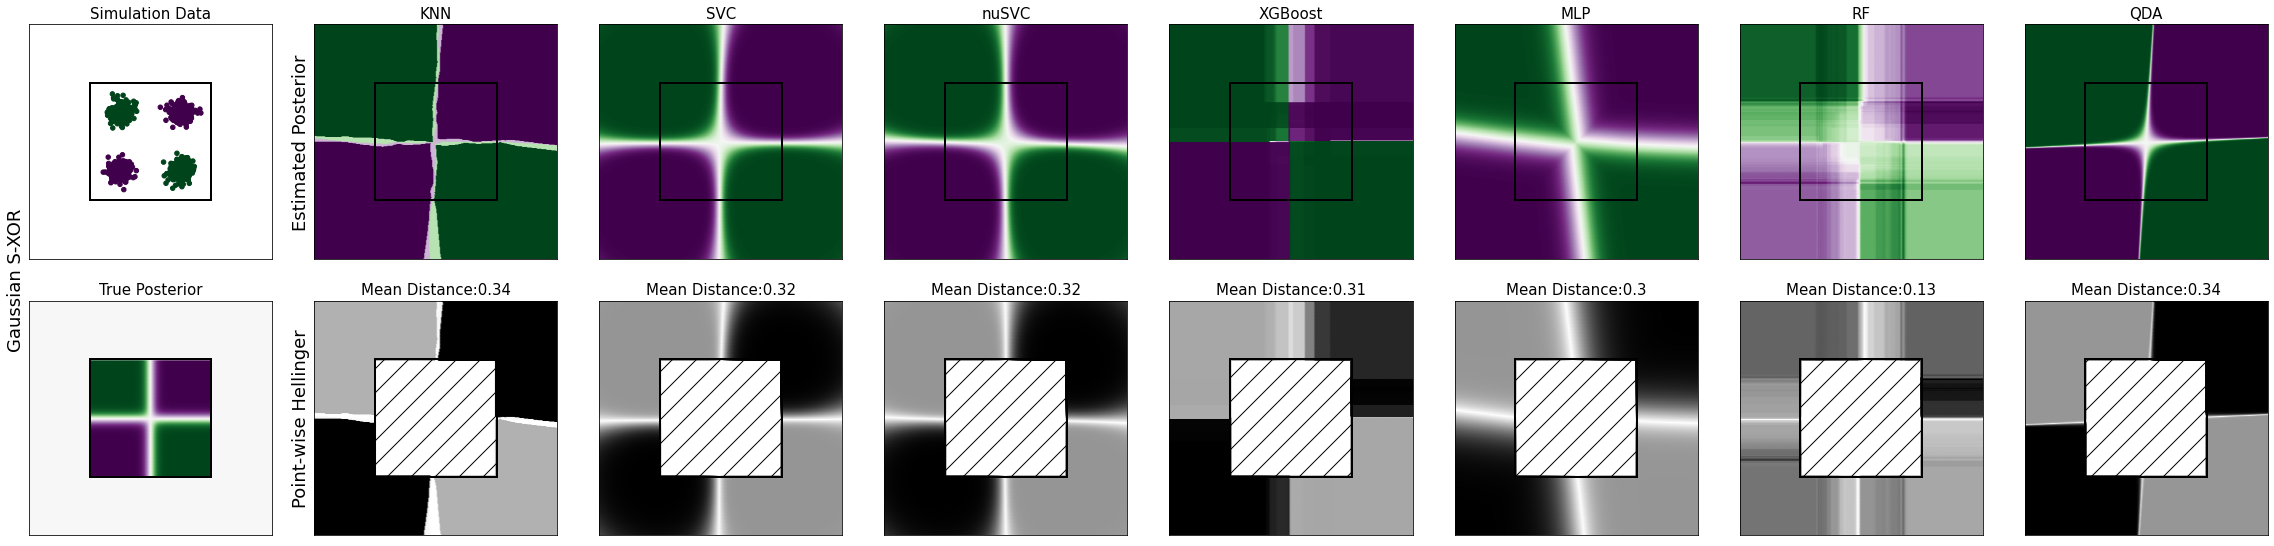

In [313]:
plot_posterior(h=0.01, enable=[0,0,0,1], savefile=True)

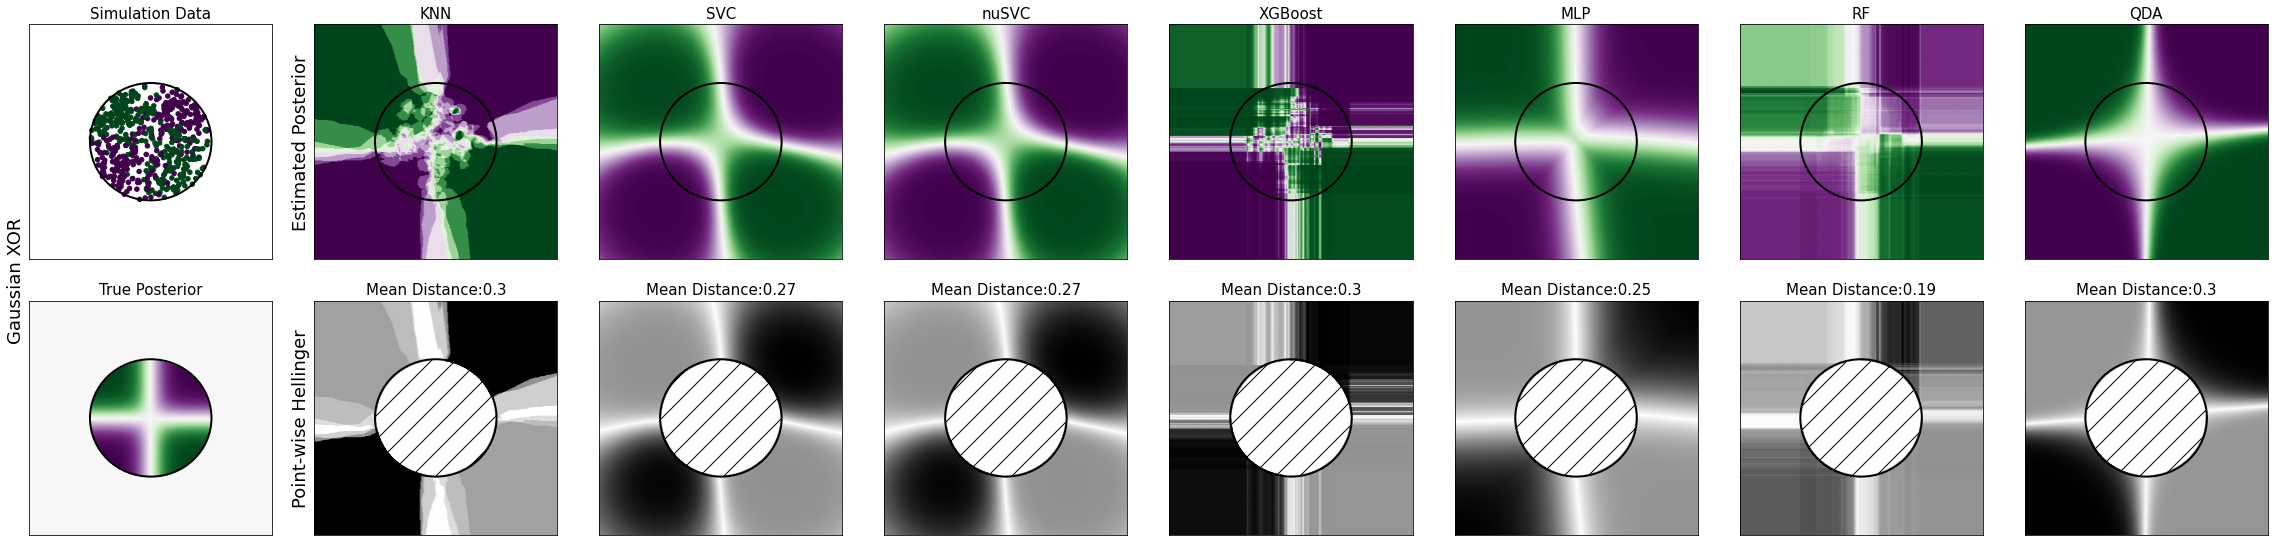

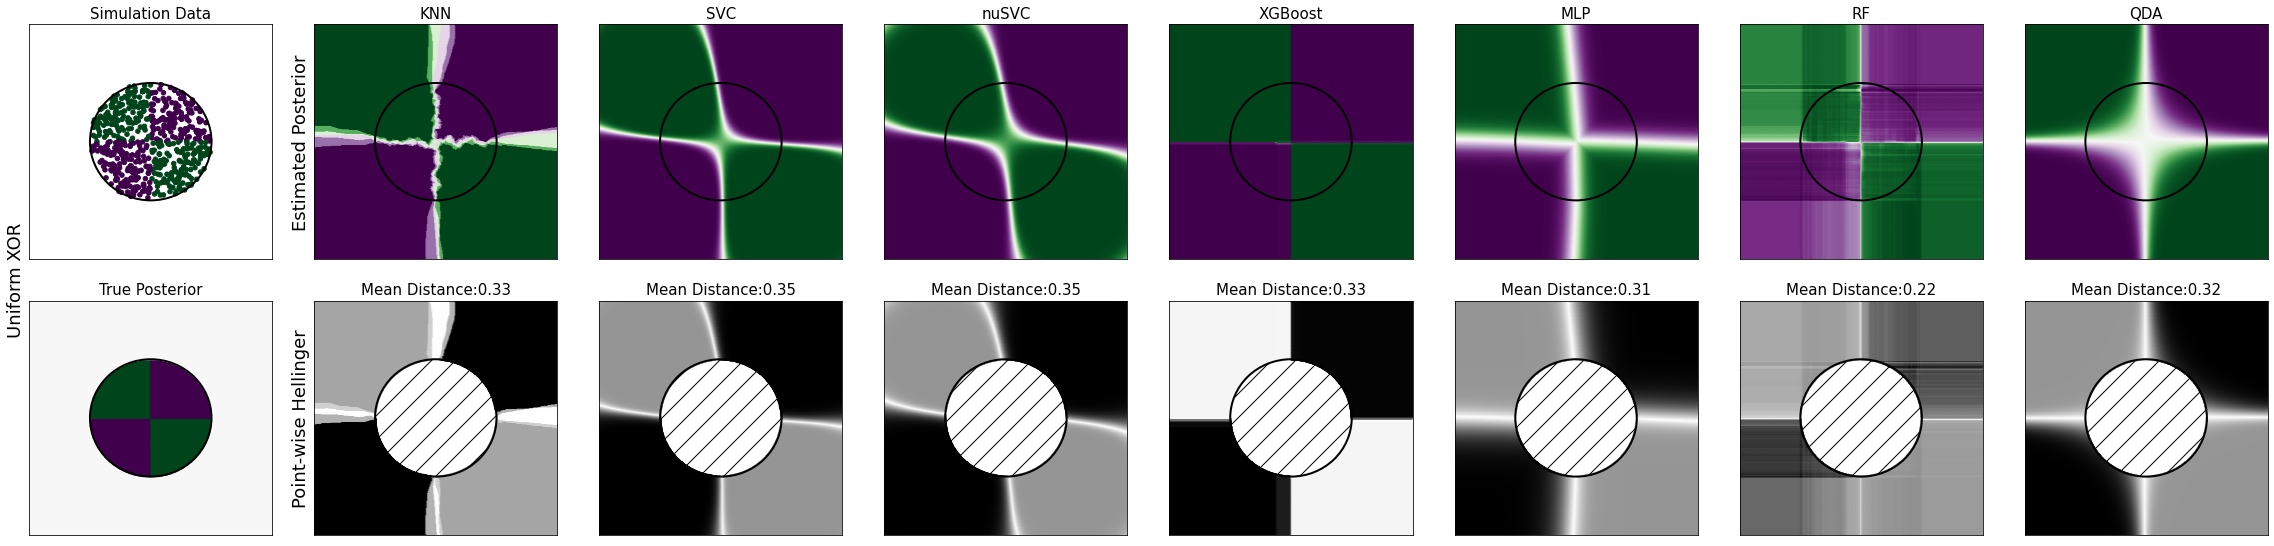

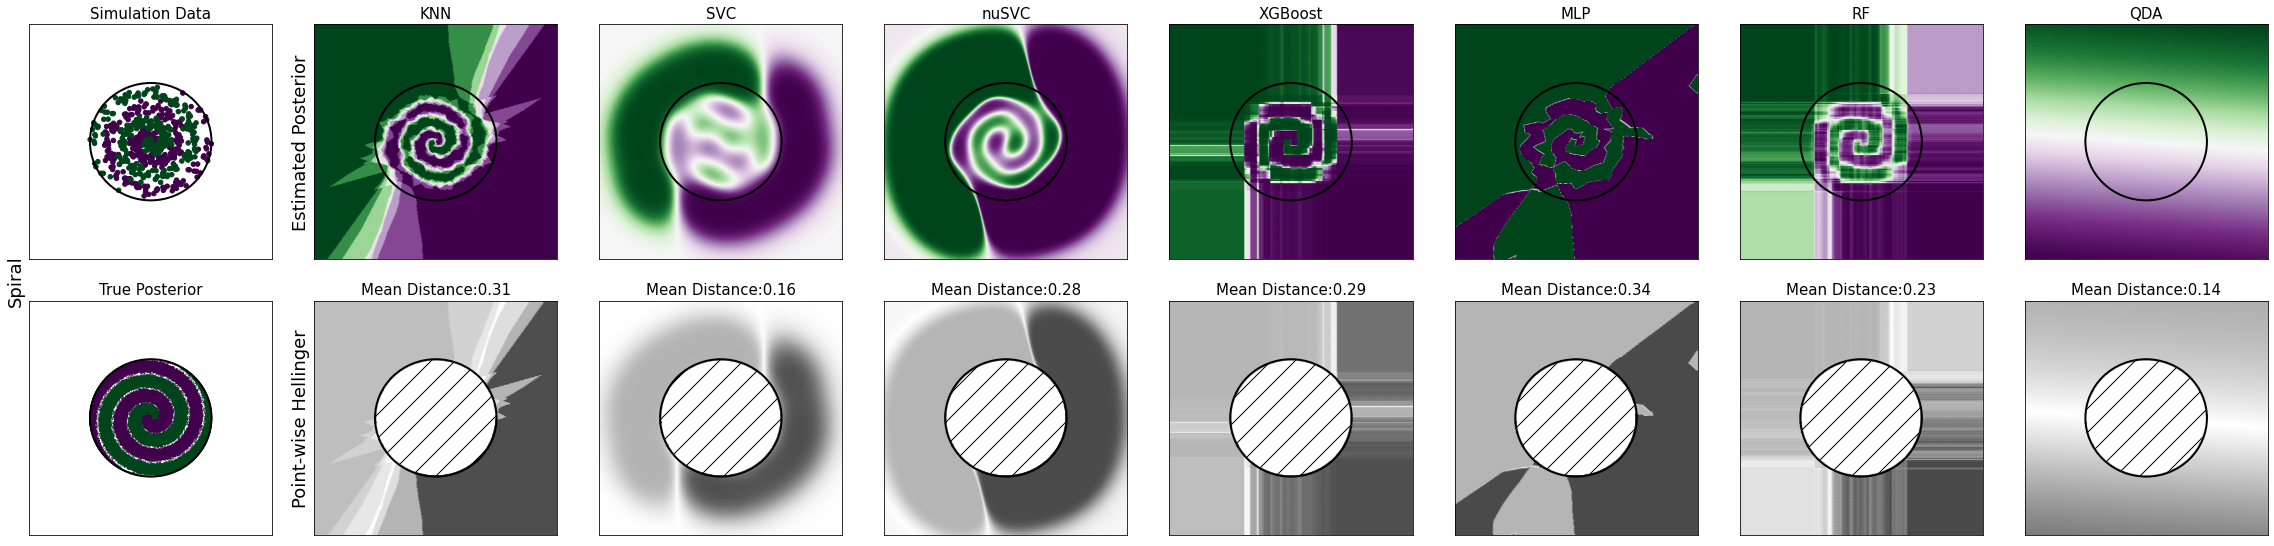

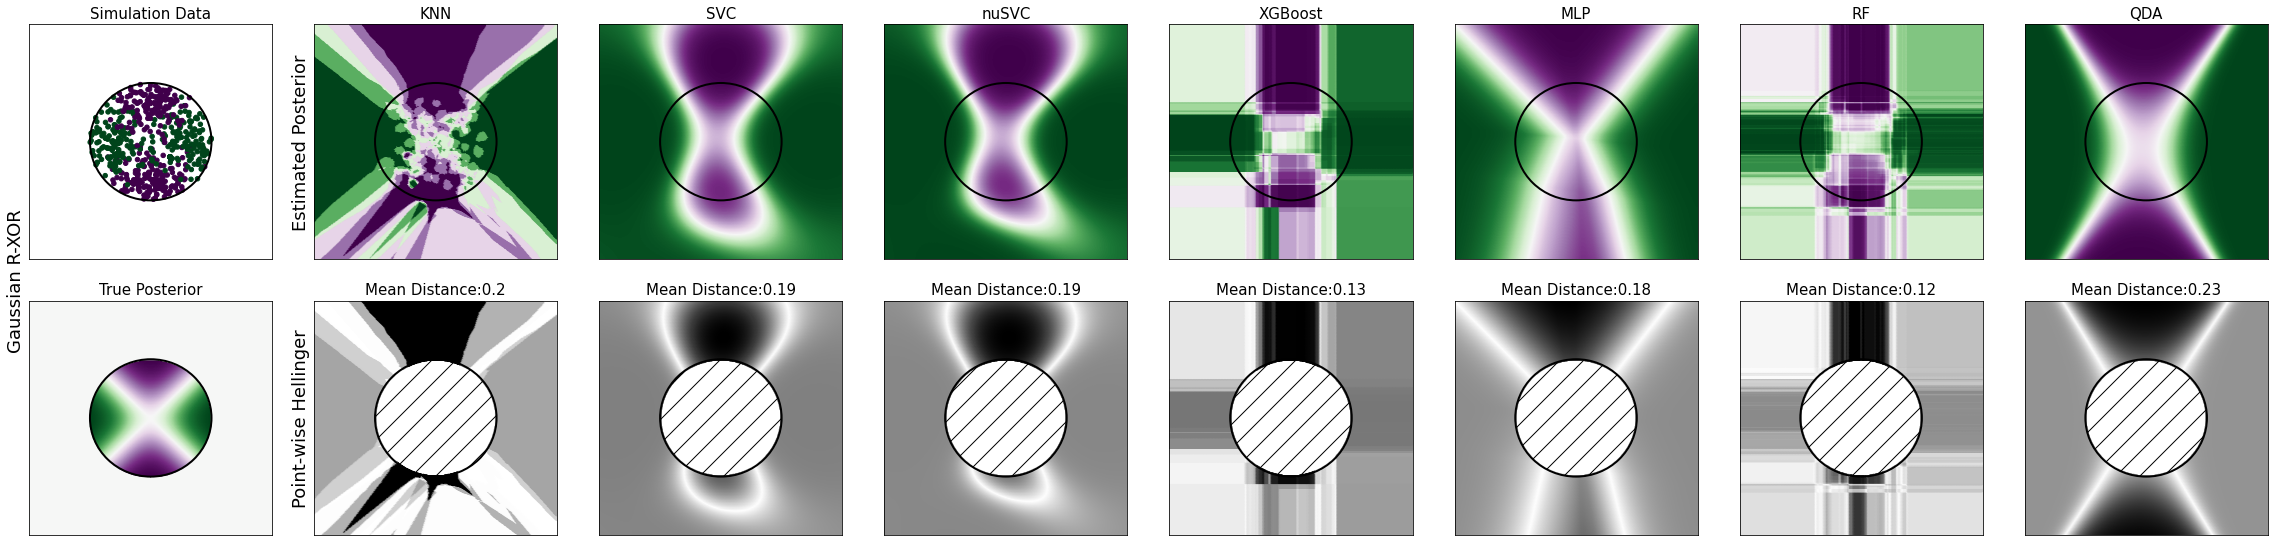

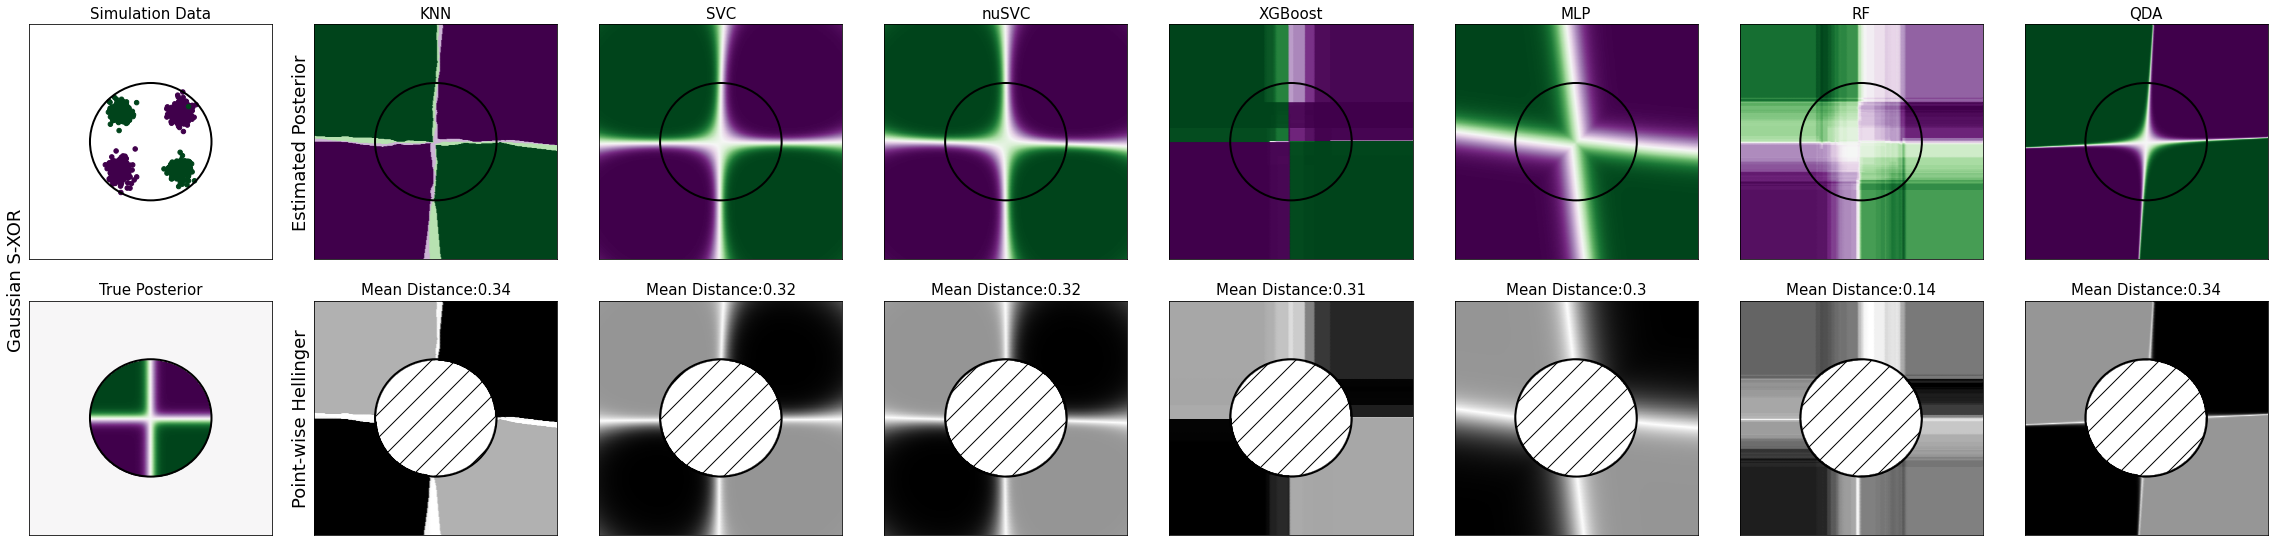

In [493]:
plot_posterior(h=0.01, enable=[0,0,0,1], cc=True, savefile=True)

In [328]:
for i in range(5):
    print('#'*70)
    print(data[i])
    print('#'*70)
    for j in range(7):
        print(select_clf(i)[j])
    # print('#'*70)

######################################################################
Gaussian XOR
######################################################################
KNeighborsClassifier(leaf_size=10)
SVC(gamma='auto', probability=True)
NuSVC(gamma='auto', probability=True)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05263157894736842, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=256, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
MLPClassifier(alpha=0, hidden_layer_sizes=100, learning_rate_init=0.0001,
              max_iter=7000)
RandomForestClassifier(max_depth=9, n_esti

## Mean Helligner comparison

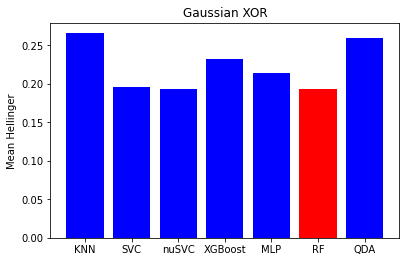

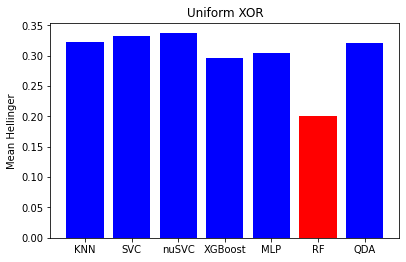

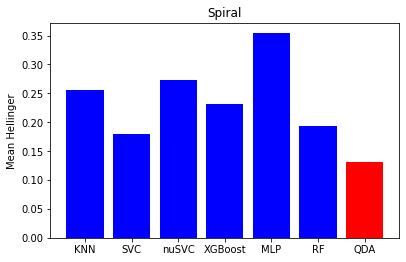

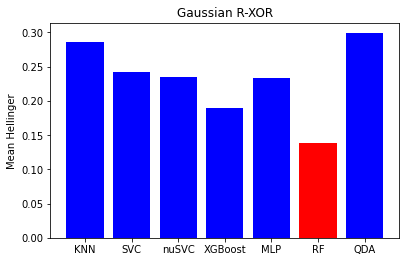

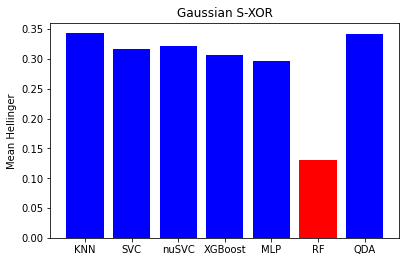

In [311]:
# fig, ax = plt.subplots(1,5, figsize=(7*5,4))
for j in range(5):
    score = []
    for i in range(7):
        score.append(OUT_hellinger[j][i].mean())

    color = np.zeros(7)#.astype(int)
    color[np.argmin(score)] = 1
    colors = ['blue' if i == 0 else 'red' for i in color]

    plt.figure()
    plt.bar(mods,score,color=colors)
    plt.ylabel('Mean Hellinger')
    plt.title(data[j]);
    path = 'figs/' + str(datetime.today())[:10] + '_' + data[j] + '_bar.png'# + '(' + str(h) + ')'
    plt.tight_layout(pad=2)
    plt.savefig(path, bbox='tight')

## Bar plots with CIRCULAR bbox

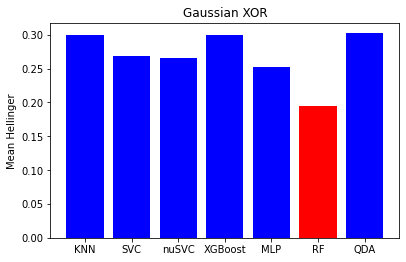

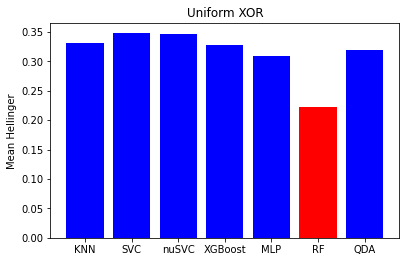

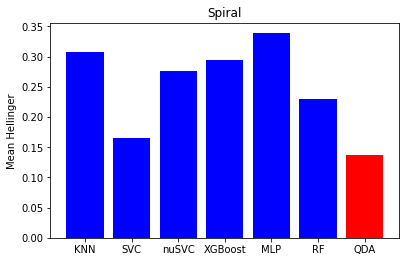

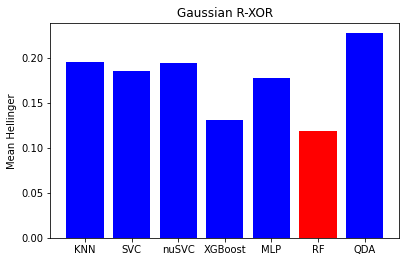

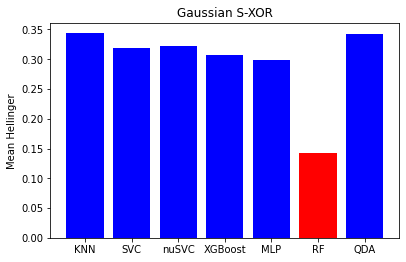

In [486]:
# fig, ax = plt.subplots(1,5, figsize=(7*5,4))
for j in range(5):
    score = []
    for i in range(7):
        score.append(COUT_hellinger[j][i].mean())

    color = np.zeros(7)#.astype(int)
    color[np.argmin(score)] = 1
    colors = ['blue' if i == 0 else 'red' for i in color]

    plt.figure()
    plt.bar(mods,score,color=colors)
    plt.ylabel('Mean Hellinger')
    plt.title(data[j]);
    path = 'figs/' + str(datetime.today())[:10] + '_' + data[j] + '_Cbar.png'# + '(' + str(h) + ')'
    plt.tight_layout(pad=2)
    plt.savefig(path, bbox='tight')

## DARPA Figure

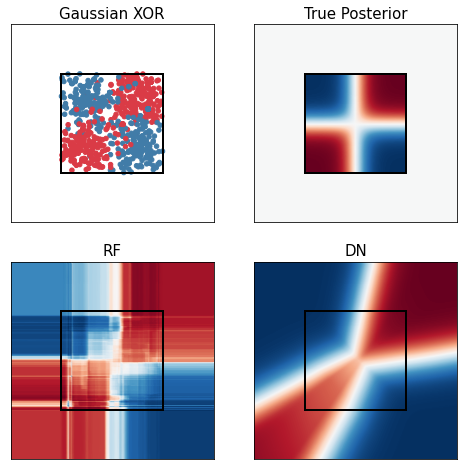

In [373]:
plot_posterior(h=0.01, enable=[0,0,1,0], savefile=False)


## NSF AI Figure

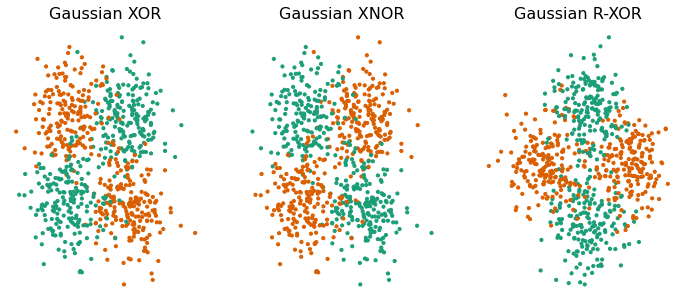

In [47]:
colors = sns.color_palette('Dark2', n_colors=5)

gausX, gausY = generate_gaussian_parity(750, mean=np.array([-1,-1]), cov_scale=0.1, angle_params=np.pi, contain=False)
gausRX, gausRY = generate_gaussian_parity(750, mean=np.array([-1,-1]), cov_scale=0.1, angle_params=np.pi/4, contain=False)

fig, ax = plt.subplots(1,3, figsize=(12,5))

ax[0].scatter(gausX[:,0],gausX[:,1], c=get_colors(colors, gausY), s=10)
ax[1].scatter(gausX[:,0],gausX[:,1], c=get_colors(colors, abs(gausY-1)), s=10)
ax[2].scatter(gausRX[:,0],gausRX[:,1], c=get_colors(colors, gausRY), s=10)

ax[0].set_title('Gaussian XOR', fontsize=16)
ax[1].set_title('Gaussian XNOR', fontsize=16)
ax[2].set_title('Gaussian R-XOR', fontsize=16)

for i in range(3):
    ax[i].axis('off')

fig.savefig('figs/NSF_AI_fig.png', bbox_inches='tight')

## Unified colorbar (in progress)

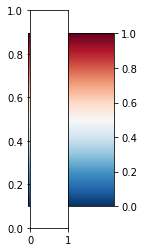

In [167]:
import pylab as pl
import numpy as np

# a = np.array([[0,1]])
# fig = plt.figure()
# axs = fig.add_subplot(111)
fig = plt.figure(figsize=(0.5*3, 4))
axs = fig.add_subplot(111)
axs = plt.imshow([[0,1]], cmap='RdBu_r')
axs = plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
axs = plt.colorbar(orientation="vertical", cax=cax)
axs = fig.add_subplot(121)



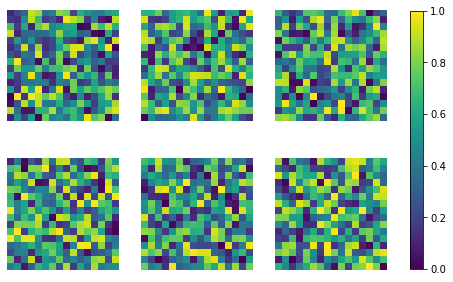

In [174]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8.5, 5))

for ax in axes.flat:
    ax.set_axis_off()
    im = ax.imshow(np.random.random((16, 16)), cmap='viridis',
                   vmin=0, vmax=1)

# notice that here we use ax param of figure.colorbar method instead of

# the cax param as the above example

axes = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)

cbar.set_ticks(np.arange(0, 1.1, 0.5))
cbar.set_ticklabels(['low', 'medium', 'high'])

plt.show()

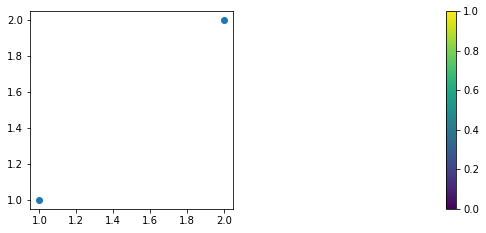

In [169]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4*2,4*2))
axs = fig.add_subplot(2,2,1)
pcm = axs.scatter([1,2],[1,2], cmap='gray')
# fig.colorbar(pcm, ax=axs)

# fig = plt.figure(figsize=(4*8,4*2))
# axs = fig.add_subplot(2,2,2)
# pcm = axs.scatter([1,2],[1,2], cmap='gray')
# fig.colorbar(pcm, ax=axs)

axs = fig.add_subplot(2,2,2)
pcm = axs.scatter([1,2],[1,2], cmap='gray')

fig.colorbar(pcm, ax=axs)
axs.remove()

plt.savefig('plot_tight.png', bbox_inches='tight')
# # fig = plt.figure(figsize=(4*8,4*2))
# axs = fig.add_subplot(2,2,3)
# pl.figure(figsize=(0.5, 4))
# axs = pl.imshow([[0,1]], cmap='RdBu_r')
# pl.gca().set_visible(False)
# axs = pl.axes([0.1, 0.2, 0.8, 0.6])
# pl.colorbar(orientation="vertical", cax=axs)

## End of notebook